<a href="https://colab.research.google.com/github/Helen205/XAI-Model/blob/main/XA%C4%B0_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HALKBANK XAI**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shapes - X: (2907, 16, 14), y: (2907, 1)
Test shapes - X: (714, 16, 14), y: (714, 1)
Model weights loaded from: /content/drive/MyDrive/ders/model.pth

Model yorumlanıyor...
Starting model interpretability analysis...
Results will be saved to: /content/drive/MyDrive/ders/model_interpretability

=== SHAP Analysis ===
Creating SHAP explainer...
Calculating SHAP values for 2 samples...


  0%|          | 0/2 [00:00<?, ?it/s]

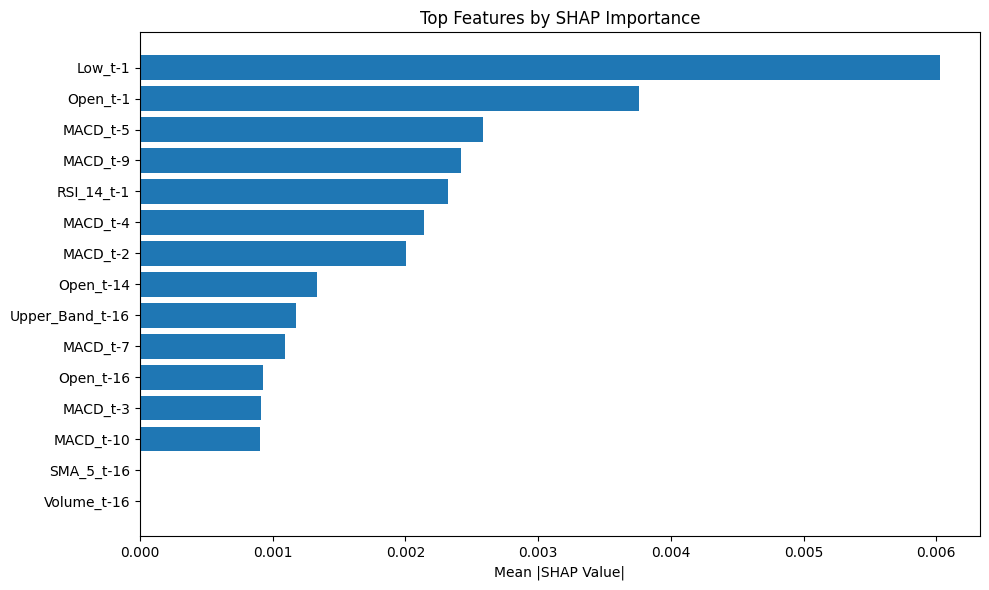


=== LIME Analysis ===
Creating LIME explainer...
Generating LIME explanations for 2 samples...

=== Temporal Importance Analysis ===


<Figure size 1200x800 with 0 Axes>

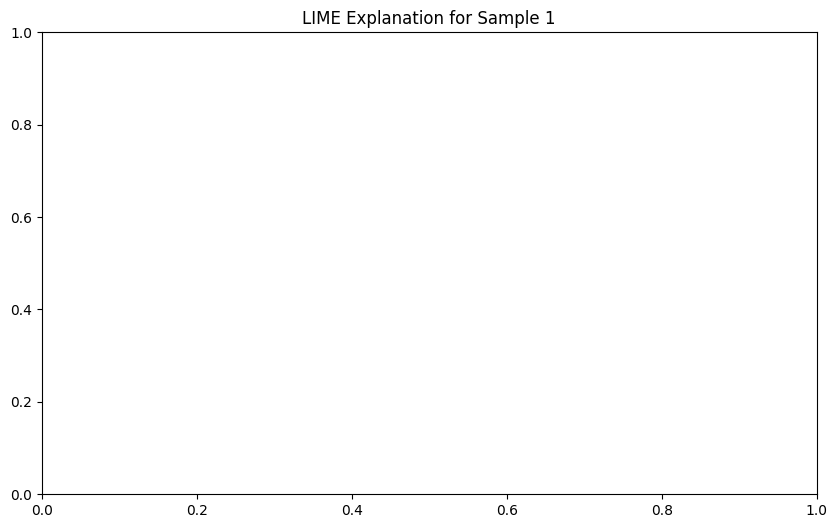

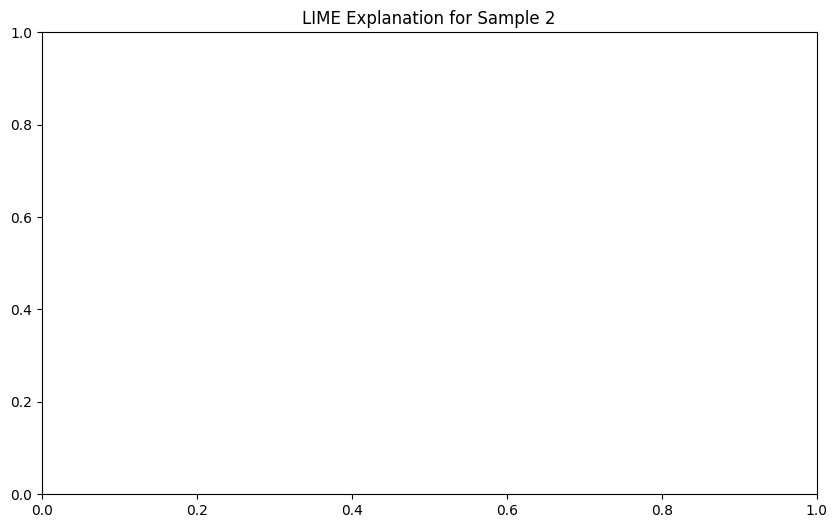

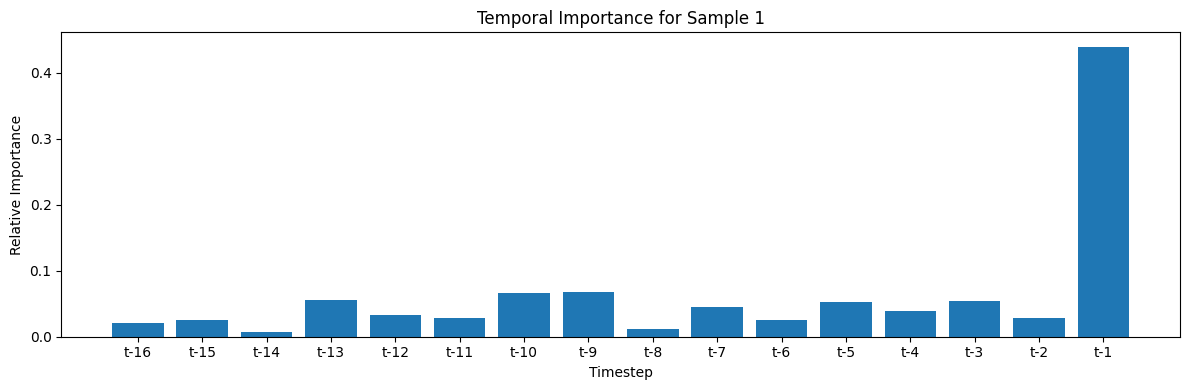

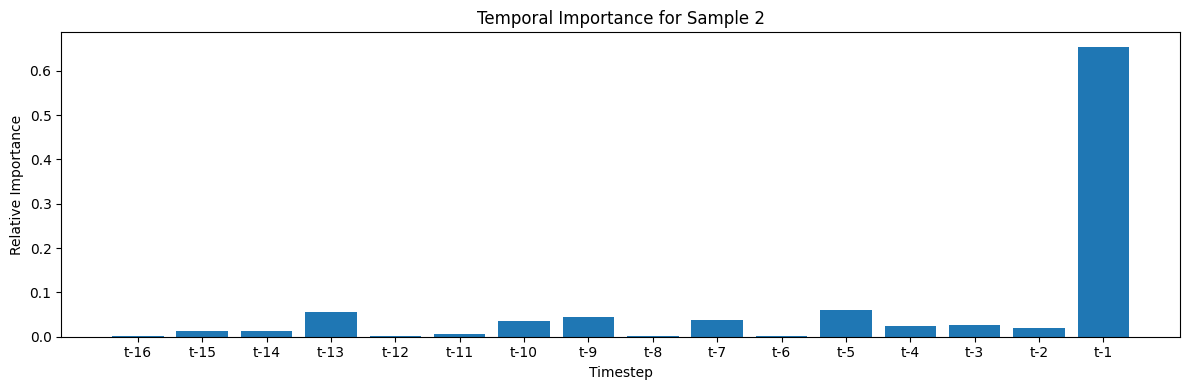

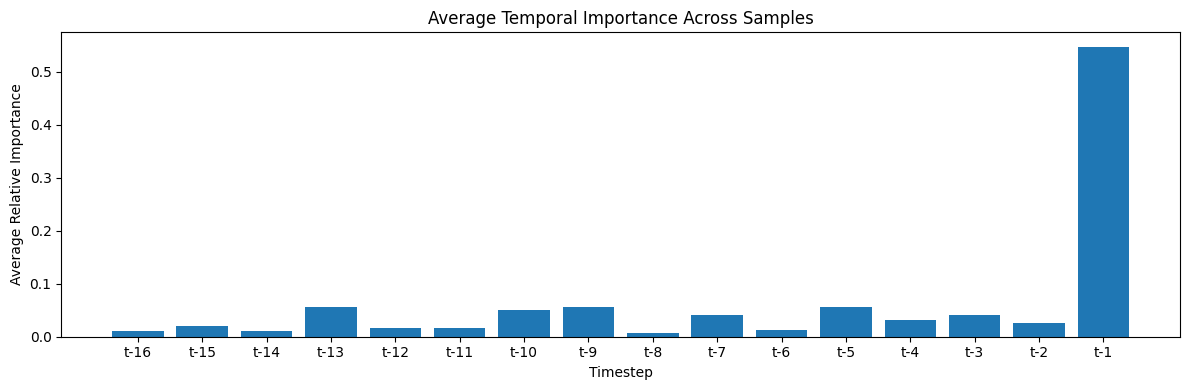


Yorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.

En önemli 2 özellik (SHAP):
             Feature  Importance
212          Low_t-1    0.006028
213         Open_t-1    0.003764
167         MACD_t-5    0.002588
111         MACD_t-9    0.002423
219       RSI_14_t-1    0.002323
181         MACD_t-4    0.002144
209         MACD_t-2    0.002006
31         Open_t-14    0.001332
10   Upper_Band_t-16    0.001176
139         MACD_t-7    0.001091


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from reformer_pytorch import Reformer
from google.colab import drive
import time
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])

drive.mount('/content/drive')

class ReformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, depth, heads, bucket_size, n_hashes, output_dim=1):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, bucket_size * 2, d_model))

        self.input_dropout = nn.Dropout(0.1)

        self.reformer = Reformer(
            dim=d_model,
            depth=depth,
            heads=heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=True
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoding
        x = self.input_dropout(x)
        x = self.reformer(x)
        x = self.layer_norm(x)
        x = x[:, -1, :]
        x = self.fc_out(x)
        return x

def prepare_features_for_interpretability(X, features):
    """
    Prepare feature names for interpretability methods with time series data

    Args:
        X: Input data with shape (samples, seq_length, features)
        features: List of feature names

    Returns:
        X_reshaped: Reshaped data with shape (samples, seq_length*features)
        feature_names: Expanded list of feature names including timesteps
    """
    seq_length = X.shape[1]
    feature_names = []

    for t in range(seq_length):
        for f in features:
            feature_names.append(f"{f}_t-{seq_length-t}")


    X_reshaped = X.reshape(X.shape[0], -1)

    return X_reshaped, feature_names

def explain_with_shap(model, X_train, X_test, features, device, num_background=20, num_samples=2):
    """
    Generate SHAP explanations for the transformer model with error handling
    """
    model.eval()


    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)


    background = X_train_reshaped[:num_background]


    def model_predict(x):
      batch_size = x.shape[0]
      x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
      x_tensor = torch.FloatTensor(x_reshaped).to(device)  # Use the GPU


      sub_batch_size = 1
      outputs = []

      for i in range(0, batch_size, sub_batch_size):
          sub_batch = x_tensor[i:i+sub_batch_size]
          with torch.no_grad():
              sub_output = model(sub_batch)
          outputs.append(sub_output.cpu().numpy())

      return np.concatenate(outputs, axis=0)


    print("Creating SHAP explainer...")

    explainer = shap.KernelExplainer(model_predict, background)


    samples_to_explain = X_test_reshaped[:num_samples]

    print(f"Calculating SHAP values for {num_samples} samples...")

    shap_values = explainer.shap_values(samples_to_explain)


    if isinstance(shap_values, list):
        shap_values_for_importance = shap_values[0] if isinstance(shap_values, list) else shap_values
    else:
        shap_values_for_importance = shap_values

    if len(shap_values_for_importance.shape) > 2:
        shap_values_for_importance = shap_values_for_importance.reshape(shap_values_for_importance.shape[0], -1)

    feature_importance = np.abs(shap_values_for_importance).mean(0)

    if len(feature_names) != len(feature_importance):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importance array length ({len(feature_importance)})")
        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_names = feature_names + [f"Unknown_{i}" for i in range(len(feature_importance) - len(feature_names))]

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    top_n = 15
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(12, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Ortalama |SHAP Değeri|')
    plt.title(f'En Önemli {top_n} Özellik (SHAP)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    feature_importance_df.to_csv(f'{result_dir}/shap_feature_importance.csv')

    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, samples_to_explain, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{result_dir}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating SHAP summary plot: {e}")

    return {
        'shap_values': shap_values,
        'feature_importance': feature_importance_df
    }

def explain_with_lime(model, X_train, X_test, features, device, num_samples=2):
    """
    Generate LIME explanations for the transformer model
    """
    model_cpu = model.to('cpu')
    model_cpu.eval()

    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)

    def predict_fn(x):
        batch_size = x.shape[0]
        x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
        x_tensor = torch.FloatTensor(x_reshaped)

        with torch.no_grad():
            output = model_cpu(x_tensor)
        return output.numpy()

    print("Creating LIME explainer...")
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_reshaped,
        feature_names=feature_names,
        discretize_continuous=True,
        mode='regression'
    )

    print(f"Generating LIME explanations for {num_samples} samples...")
    explanations = []

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    for i in range(min(num_samples, len(X_test_reshaped))):
        try:
            exp = explainer.explain_instance(
                X_test_reshaped[i],
                predict_fn,
                num_features=20
            )
            explanations.append(exp)

            plt.figure(figsize=(10, 6))
            plt.title(f'LIME Explanation for Sample {i+1}')
            exp.as_pyplot_figure()
            plt.tight_layout()

            plt.savefig(f'{result_dir}/lime_explanation_sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            print(f"Error explaining sample {i}: {e}")

    model.to(device)

    return explanations

def analyze_temporal_importance(model, X_test, features, device, num_samples=2):
    """
    Analyze how each timestep contributes to the prediction

    Args:
        model: Trained PyTorch model
        X_test: Test data
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')
        num_samples: Number of samples to analyze
    """
    model.eval()

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    all_importances = []

    for sample_idx in range(min(num_samples, len(X_test))):
        sequence = X_test[sample_idx:sample_idx+1]
        sequence_tensor = torch.FloatTensor(sequence).to(device)

        with torch.no_grad():
            original_pred = model(sequence_tensor).item()

        importances = np.zeros(sequence.shape[1])
        for t in range(sequence.shape[1]):
            masked = sequence.copy()
            masked[0, t, :] = 0
            masked_tensor = torch.FloatTensor(masked).to(device)

            with torch.no_grad():
                masked_pred = model(masked_tensor).item()

            importances[t] = abs(original_pred - masked_pred)

        importances = importances / importances.sum() if importances.sum() > 0 else importances
        all_importances.append(importances)

        plt.figure(figsize=(12, 4))
        plt.bar(range(sequence.shape[1]), importances)
        plt.xlabel('Timestep')
        plt.ylabel('Relative Importance')
        plt.title(f'Temporal Importance for Sample {sample_idx+1}')
        plt.xticks(range(sequence.shape[1]), [f't-{sequence.shape[1]-i}' for i in range(sequence.shape[1])])
        plt.tight_layout()

        plt.savefig(f'{result_dir}/temporal_importance_sample_{sample_idx+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

    avg_importance = np.mean(all_importances, axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(avg_importance)), avg_importance)
    plt.xlabel('Timestep')
    plt.ylabel('Average Relative Importance')
    plt.title('Average Temporal Importance Across Samples')
    plt.xticks(range(len(avg_importance)), [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))])
    plt.tight_layout()

    plt.savefig(f'{result_dir}/average_temporal_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame({
        'Timestep': [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))],
        'Importance': avg_importance
    }).to_csv(f'{result_dir}/temporal_importance.csv', index=False)

def run_interpretability_analysis(model, X_train, X_test, features, device):
    """
    Run comprehensive interpretability analysis on the model

    Args:
        model: Trained PyTorch model
        X_train: Training data with shape (samples, seq_length, features)
        X_test: Test data with shape (samples, seq_length, features)
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')

    Returns:
        Dictionary with results of the analysis
    """
    print("Starting model interpretability analysis...")

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    print(f"Results will be saved to: {result_dir}")

    print("\n=== SHAP Analysis ===")
    shap_results = explain_with_shap(model, X_train, X_test, features, device)

    print("\n=== LIME Analysis ===")
    lime_results = explain_with_lime(model, X_train, X_test, features, device)

    print("\n=== Temporal Importance Analysis ===")
    analyze_temporal_importance(model, X_test, features, device)

    return {
        'shap_results': shap_results,
        'lime_results': lime_results
    }

def prepare_sequences(data, bucket_size=8):
    """Sekans hazırlama fonksiyonu"""
    seq_length = bucket_size * 2
    xs = []
    ys = []

    close_index = 0

    for i in range(0, len(data) - seq_length - 1, 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length, close_index:close_index+1]
        if len(x) == seq_length:
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)

class FinancialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def interpret_existing_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    drive.mount('/content/drive')

    features = [
        'Close',
        'High',
        'Low',
        'Open',
        'Volume',
        'SMA_5',
        'SMA_10',
        'SMA_20',
        'SMA_50',
        'RSI_14',
        'Upper_Band',
        'Middle_Band',
        'Lower_Band',
        'MACD',
    ]

    bucket_size = 8
    seq_length = bucket_size * 2

    model_params = {
        'input_dim': len(features),
        'd_model': 32,
        'depth': 1,
        'heads': 2,
        'bucket_size': bucket_size,
        'n_hashes': 2,
        'output_dim': 1
    }

    try:
        dosya_yolu = '/content/drive/MyDrive/ders/HALKB.IS.csv'
        df = pd.read_csv(dosya_yolu)

        close_scaler = MinMaxScaler()
        df['Close_scaled'] = close_scaler.fit_transform(df[['Close']])

        other_features = [f for f in features if f != 'Close']
        scaled_features = {}
        for feature in other_features:
            scaler = MinMaxScaler()
            df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])
            scaled_features[feature] = scaler

        scaled_columns = [f'{f}_scaled' for f in features]
        scaled_data = df[scaled_columns].values

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]


        X_train, y_train = prepare_sequences(train_data, bucket_size)
        X_test, y_test = prepare_sequences(test_data, bucket_size)

        print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
        print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

        model = ReformerTimeSeries(**model_params).to(device)

        model_path = '/content/drive/MyDrive/ders/model.pth'
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Model weights loaded from: {model_path}")
        else:
            model.load_state_dict(checkpoint)
            print(f"Model (direct state_dict) loaded from: {model_path}")

        model.eval()

        print("\nModel yorumlanıyor...")
        interpretability_results = run_interpretability_analysis(
            model=model,
            X_train=X_train,
            X_test=X_test,
            features=features,
            device=device
        )

        print("\nYorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.")
        print("\nEn önemli 10 özellik (SHAP):")
        print(interpretability_results['shap_results']['feature_importance'].head(10))

    except Exception as e:
        print(f"Bir hata oluştu: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    interpret_existing_model()

# **ALBARAKA XAI**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shapes - X: (2939, 16, 14), y: (2939, 1)
Test shapes - X: (722, 16, 14), y: (722, 1)
Model weights loaded from: /content/drive/MyDrive/ders/model.pth

Model yorumlanıyor...
Starting model interpretability analysis...
Results will be saved to: /content/drive/MyDrive/ders/model_interpretability

=== SHAP Analysis ===
Creating SHAP explainer...
Calculating SHAP values for 2 samples...


  0%|          | 0/2 [00:00<?, ?it/s]

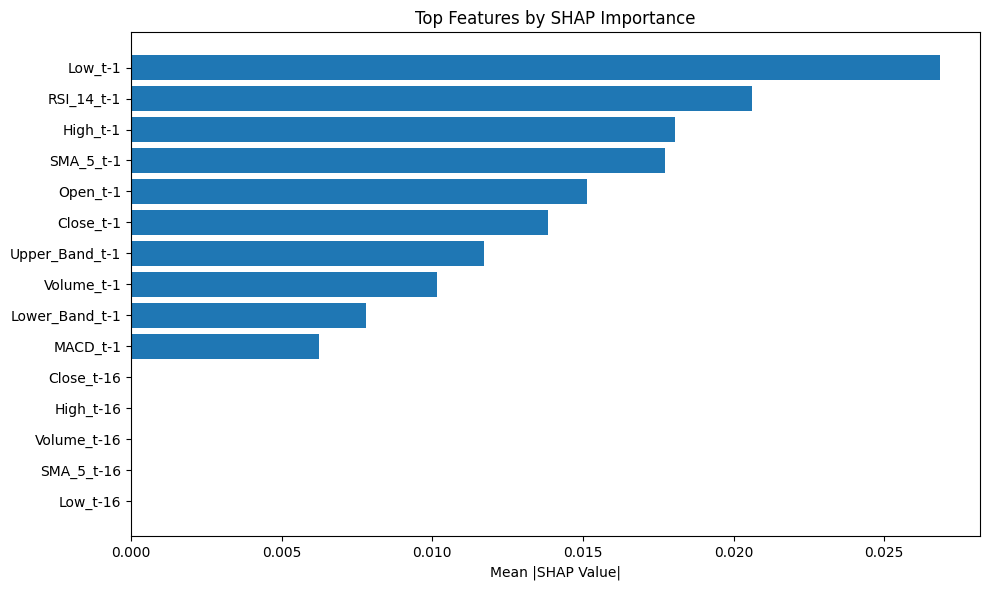


=== LIME Analysis ===
Creating LIME explainer...
Generating LIME explanations for 2 samples...

=== Temporal Importance Analysis ===


<Figure size 1200x800 with 0 Axes>

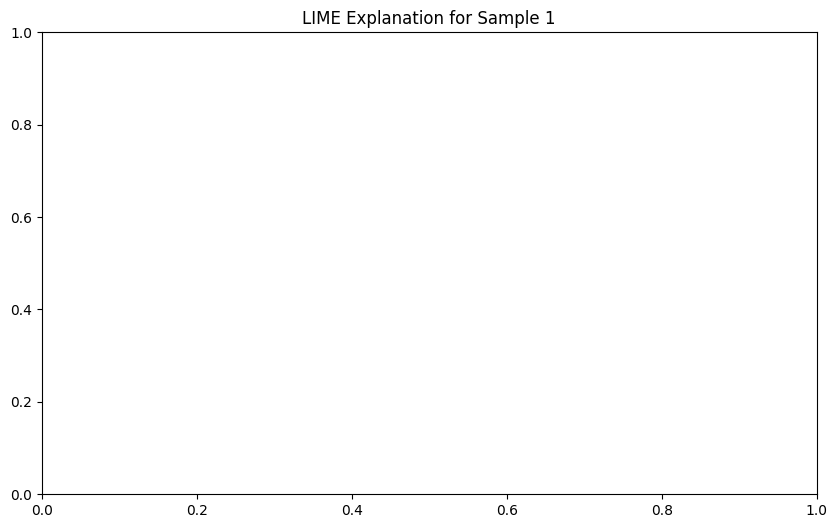

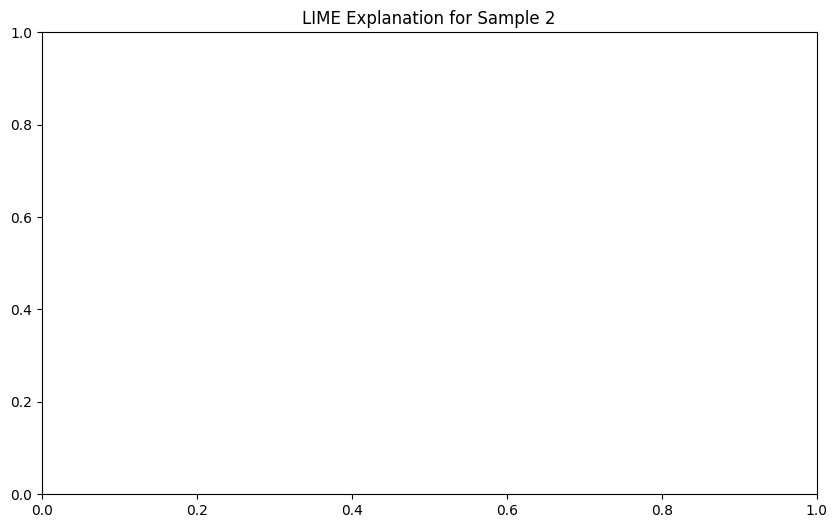

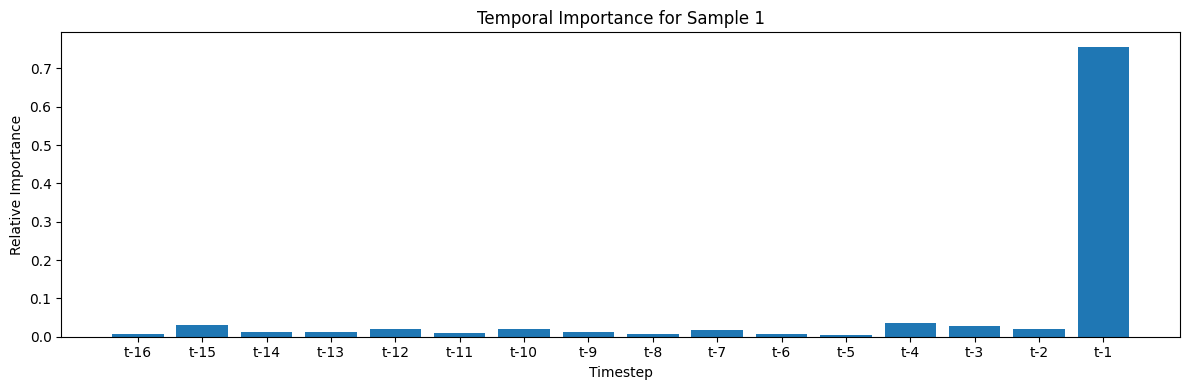

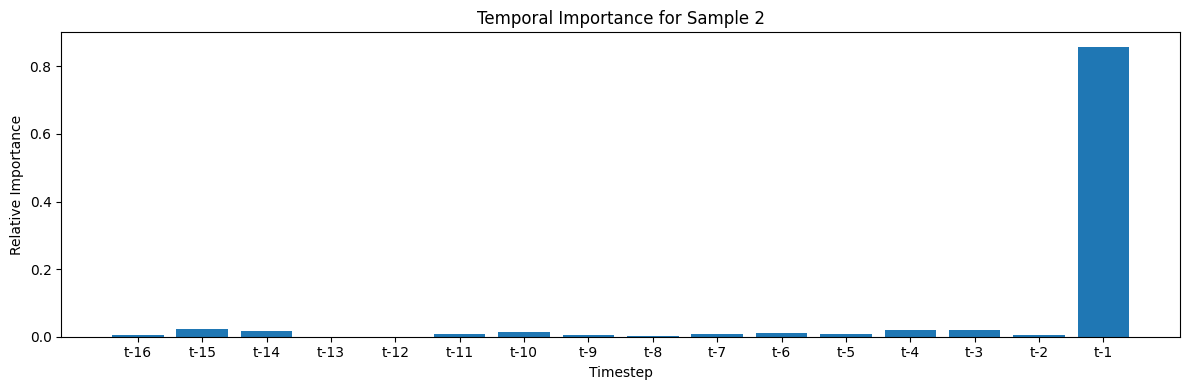

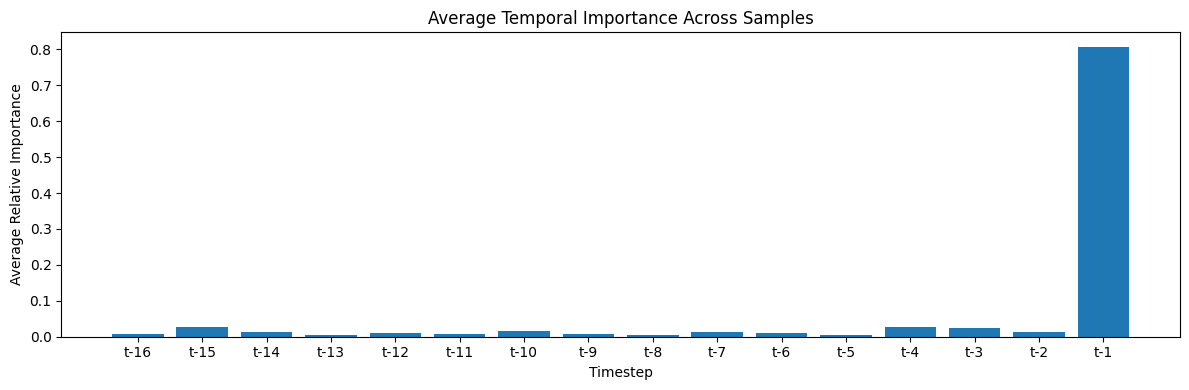


Yorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.

En önemli 10 özellik (SHAP):
            Feature  Importance
212         Low_t-1    0.026834
219      RSI_14_t-1    0.020602
211        High_t-1    0.018044
215       SMA_5_t-1    0.017724
213        Open_t-1    0.015135
210       Close_t-1    0.013851
220  Upper_Band_t-1    0.011707
214      Volume_t-1    0.010157
222  Lower_Band_t-1    0.007785
223        MACD_t-1    0.006231


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from reformer_pytorch import Reformer
from google.colab import drive
import time
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])

drive.mount('/content/drive')

class ReformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, depth, heads, bucket_size, n_hashes, output_dim=1):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, bucket_size * 2, d_model))

        self.input_dropout = nn.Dropout(0.1)

        self.reformer = Reformer(
            dim=d_model,
            depth=depth,
            heads=heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=True
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoding
        x = self.input_dropout(x)
        x = self.reformer(x)
        x = self.layer_norm(x)
        x = x[:, -1, :]
        x = self.fc_out(x)
        return x

def prepare_features_for_interpretability(X, features):
    """
    Prepare feature names for interpretability methods with time series data

    Args:
        X: Input data with shape (samples, seq_length, features)
        features: List of feature names

    Returns:
        X_reshaped: Reshaped data with shape (samples, seq_length*features)
        feature_names: Expanded list of feature names including timesteps
    """
    seq_length = X.shape[1]
    feature_names = []

    for t in range(seq_length):
        for f in features:
            feature_names.append(f"{f}_t-{seq_length-t}")


    X_reshaped = X.reshape(X.shape[0], -1)

    return X_reshaped, feature_names

def explain_with_shap(model, X_train, X_test, features, device, num_background=20, num_samples=2):
    """
    Generate SHAP explanations for the transformer model with error handling
    """
    model.eval()


    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)


    background = X_train_reshaped[:num_background]


    def model_predict(x):
      batch_size = x.shape[0]
      x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
      x_tensor = torch.FloatTensor(x_reshaped).to(device)  # Use the GPU


      sub_batch_size = 1
      outputs = []

      for i in range(0, batch_size, sub_batch_size):
          sub_batch = x_tensor[i:i+sub_batch_size]
          with torch.no_grad():
              sub_output = model(sub_batch)
          outputs.append(sub_output.cpu().numpy())

      return np.concatenate(outputs, axis=0)


    print("Creating SHAP explainer...")

    explainer = shap.KernelExplainer(model_predict, background)


    samples_to_explain = X_test_reshaped[:num_samples]

    print(f"Calculating SHAP values for {num_samples} samples...")

    shap_values = explainer.shap_values(samples_to_explain)


    if isinstance(shap_values, list):
        shap_values_for_importance = shap_values[0] if isinstance(shap_values, list) else shap_values
    else:
        shap_values_for_importance = shap_values

    if len(shap_values_for_importance.shape) > 2:
        shap_values_for_importance = shap_values_for_importance.reshape(shap_values_for_importance.shape[0], -1)

    feature_importance = np.abs(shap_values_for_importance).mean(0)

    if len(feature_names) != len(feature_importance):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importance array length ({len(feature_importance)})")
        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_names = feature_names + [f"Unknown_{i}" for i in range(len(feature_importance) - len(feature_names))]

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    top_n = 15
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(12, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Ortalama |SHAP Değeri|')
    plt.title(f'En Önemli {top_n} Özellik (SHAP)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    feature_importance_df.to_csv(f'{result_dir}/shap_feature_importance.csv')

    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, samples_to_explain, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{result_dir}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating SHAP summary plot: {e}")

    return {
        'shap_values': shap_values,
        'feature_importance': feature_importance_df
    }

def explain_with_lime(model, X_train, X_test, features, device, num_samples=2):
    """
    Generate LIME explanations for the transformer model
    """
    model_cpu = model.to('cpu')
    model_cpu.eval()

    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)

    def predict_fn(x):
        batch_size = x.shape[0]
        x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
        x_tensor = torch.FloatTensor(x_reshaped)

        with torch.no_grad():
            output = model_cpu(x_tensor)
        return output.numpy()

    print("Creating LIME explainer...")
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_reshaped,
        feature_names=feature_names,
        discretize_continuous=True,
        mode='regression'
    )

    print(f"Generating LIME explanations for {num_samples} samples...")
    explanations = []

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    for i in range(min(num_samples, len(X_test_reshaped))):
        try:
            exp = explainer.explain_instance(
                X_test_reshaped[i],
                predict_fn,
                num_features=20
            )
            explanations.append(exp)

            plt.figure(figsize=(10, 6))
            plt.title(f'LIME Explanation for Sample {i+1}')
            exp.as_pyplot_figure()
            plt.tight_layout()

            plt.savefig(f'{result_dir}/lime_explanation_sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            print(f"Error explaining sample {i}: {e}")

    model.to(device)

    return explanations

def analyze_temporal_importance(model, X_test, features, device, num_samples=2):
    """
    Analyze how each timestep contributes to the prediction

    Args:
        model: Trained PyTorch model
        X_test: Test data
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')
        num_samples: Number of samples to analyze
    """
    model.eval()

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    all_importances = []

    for sample_idx in range(min(num_samples, len(X_test))):
        sequence = X_test[sample_idx:sample_idx+1]
        sequence_tensor = torch.FloatTensor(sequence).to(device)

        with torch.no_grad():
            original_pred = model(sequence_tensor).item()

        importances = np.zeros(sequence.shape[1])
        for t in range(sequence.shape[1]):
            masked = sequence.copy()
            masked[0, t, :] = 0
            masked_tensor = torch.FloatTensor(masked).to(device)

            with torch.no_grad():
                masked_pred = model(masked_tensor).item()

            importances[t] = abs(original_pred - masked_pred)

        importances = importances / importances.sum() if importances.sum() > 0 else importances
        all_importances.append(importances)

        plt.figure(figsize=(12, 4))
        plt.bar(range(sequence.shape[1]), importances)
        plt.xlabel('Timestep')
        plt.ylabel('Relative Importance')
        plt.title(f'Temporal Importance for Sample {sample_idx+1}')
        plt.xticks(range(sequence.shape[1]), [f't-{sequence.shape[1]-i}' for i in range(sequence.shape[1])])
        plt.tight_layout()

        plt.savefig(f'{result_dir}/temporal_importance_sample_{sample_idx+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

    avg_importance = np.mean(all_importances, axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(avg_importance)), avg_importance)
    plt.xlabel('Timestep')
    plt.ylabel('Average Relative Importance')
    plt.title('Average Temporal Importance Across Samples')
    plt.xticks(range(len(avg_importance)), [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))])
    plt.tight_layout()

    plt.savefig(f'{result_dir}/average_temporal_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame({
        'Timestep': [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))],
        'Importance': avg_importance
    }).to_csv(f'{result_dir}/temporal_importance.csv', index=False)

def run_interpretability_analysis(model, X_train, X_test, features, device):
    """
    Run comprehensive interpretability analysis on the model

    Args:
        model: Trained PyTorch model
        X_train: Training data with shape (samples, seq_length, features)
        X_test: Test data with shape (samples, seq_length, features)
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')

    Returns:
        Dictionary with results of the analysis
    """
    print("Starting model interpretability analysis...")

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    print(f"Results will be saved to: {result_dir}")

    print("\n=== SHAP Analysis ===")
    shap_results = explain_with_shap(model, X_train, X_test, features, device)

    print("\n=== LIME Analysis ===")
    lime_results = explain_with_lime(model, X_train, X_test, features, device)

    print("\n=== Temporal Importance Analysis ===")
    analyze_temporal_importance(model, X_test, features, device)

    return {
        'shap_results': shap_results,
        'lime_results': lime_results
    }

def prepare_sequences(data, bucket_size=8):
    """Sekans hazırlama fonksiyonu"""
    seq_length = bucket_size * 2
    xs = []
    ys = []

    close_index = 0

    for i in range(0, len(data) - seq_length - 1, 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length, close_index:close_index+1]
        if len(x) == seq_length:
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)

class FinancialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def interpret_existing_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    drive.mount('/content/drive')

    features = [
        'Close',
        'High',
        'Low',
        'Open',
        'Volume',
        'SMA_5',
        'SMA_10',
        'SMA_20',
        'SMA_50',
        'RSI_14',
        'Upper_Band',
        'Middle_Band',
        'Lower_Band',
        'MACD',
    ]

    bucket_size = 8
    seq_length = bucket_size * 2

    model_params = {
        'input_dim': len(features),
        'd_model': 32,
        'depth': 1,
        'heads': 2,
        'bucket_size': bucket_size,
        'n_hashes': 2,
        'output_dim': 1
    }

    try:
        dosya_yolu = '/content/drive/MyDrive/ders/ALBRK.IS.csv'
        df = pd.read_csv(dosya_yolu)

        close_scaler = MinMaxScaler()
        df['Close_scaled'] = close_scaler.fit_transform(df[['Close']])

        other_features = [f for f in features if f != 'Close']
        scaled_features = {}
        for feature in other_features:
            scaler = MinMaxScaler()
            df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])
            scaled_features[feature] = scaler

        scaled_columns = [f'{f}_scaled' for f in features]
        scaled_data = df[scaled_columns].values

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]


        X_train, y_train = prepare_sequences(train_data, bucket_size)
        X_test, y_test = prepare_sequences(test_data, bucket_size)

        print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
        print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

        model = ReformerTimeSeries(**model_params).to(device)

        model_path = '/content/drive/MyDrive/ders/model.pth'
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Model weights loaded from: {model_path}")
        else:
            model.load_state_dict(checkpoint)
            print(f"Model (direct state_dict) loaded from: {model_path}")

        model.eval()

        print("\nModel yorumlanıyor...")
        interpretability_results = run_interpretability_analysis(
            model=model,
            X_train=X_train,
            X_test=X_test,
            features=features,
            device=device
        )

        print("\nYorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.")
        print("\nEn önemli 10 özellik (SHAP):")
        print(interpretability_results['shap_results']['feature_importance'].head(10))

    except Exception as e:
        print(f"Bir hata oluştu: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    interpret_existing_model()

# **YAPI KREDİ BANK XAI**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shapes - X: (2907, 16, 14), y: (2907, 1)
Test shapes - X: (714, 16, 14), y: (714, 1)
Model (direct state_dict) loaded from: /content/drive/MyDrive/ders/model.pth

Model yorumlanıyor...
Starting model interpretability analysis...
Results will be saved to: /content/drive/MyDrive/ders/model_interpretability

=== SHAP Analysis ===
Creating SHAP explainer...
Calculating SHAP values for 2 samples...


  0%|          | 0/2 [00:00<?, ?it/s]

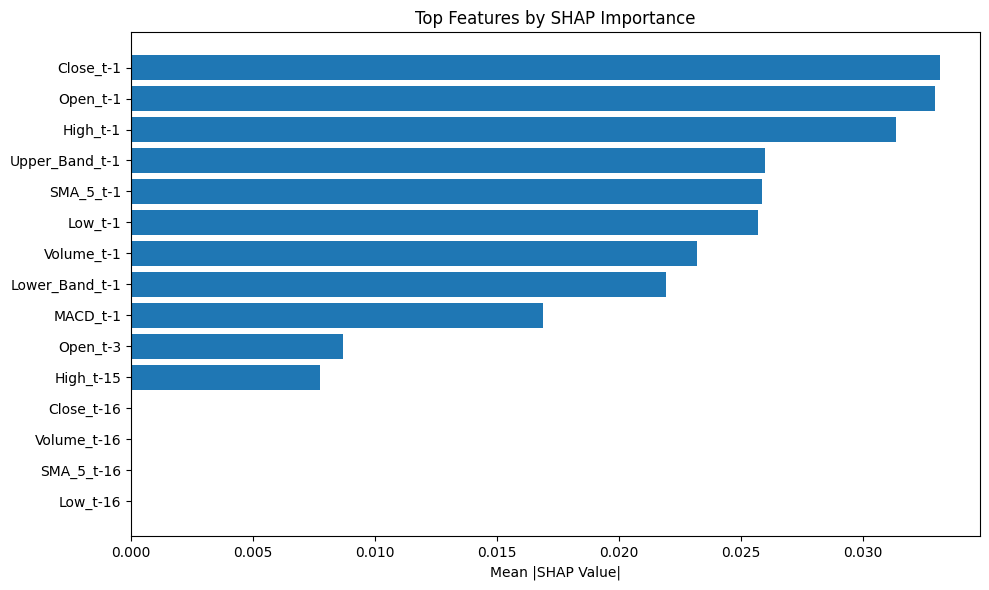


=== LIME Analysis ===
Creating LIME explainer...
Generating LIME explanations for 2 samples...

=== Temporal Importance Analysis ===


<Figure size 1200x800 with 0 Axes>

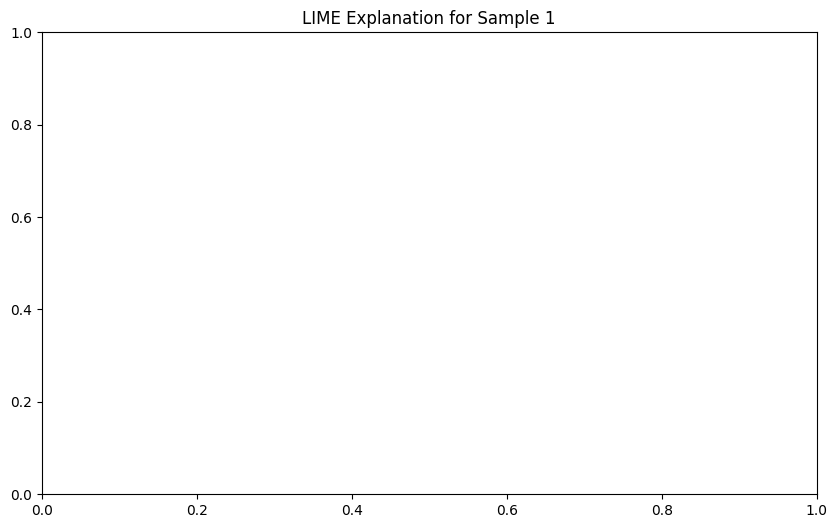

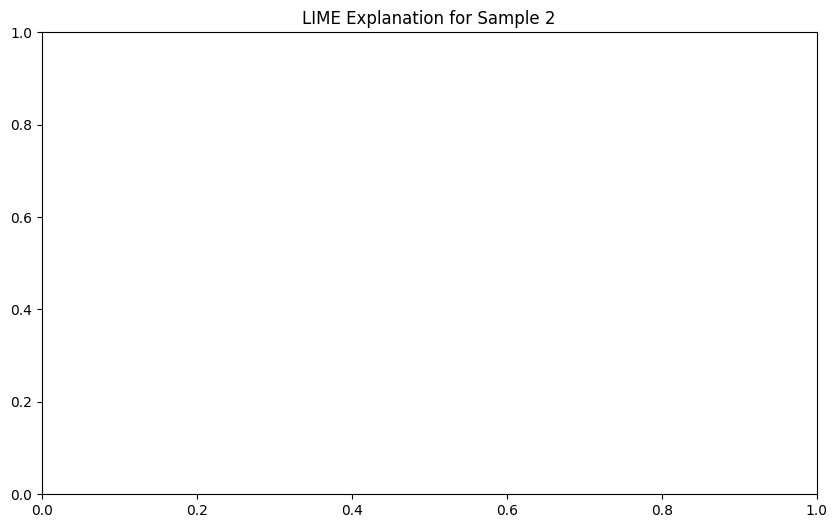

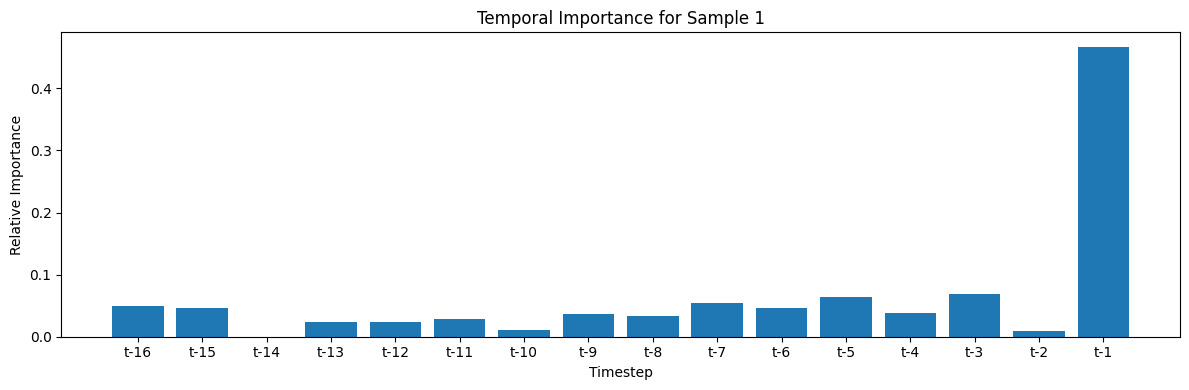

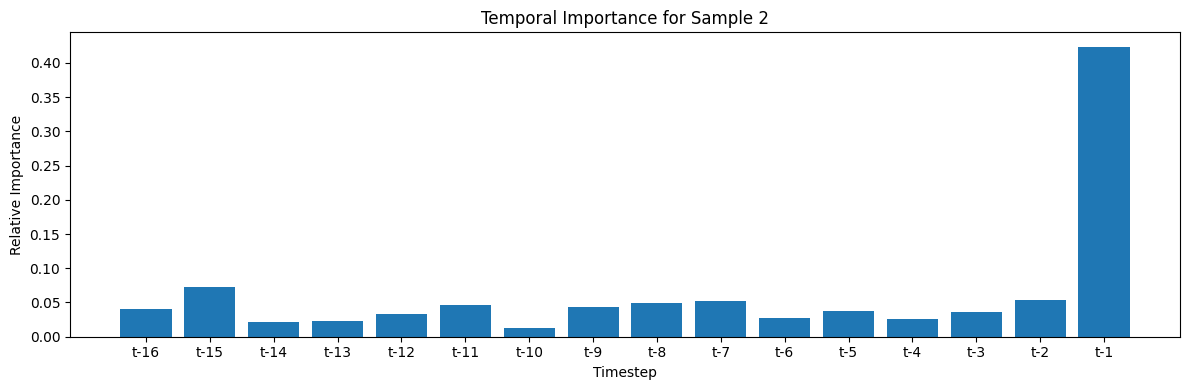

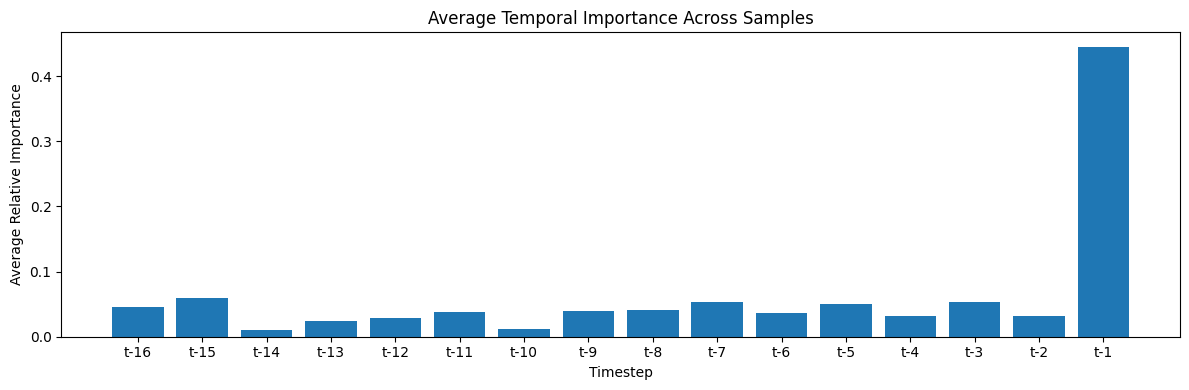


Yorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.

En önemli 10 özellik (SHAP):
            Feature  Importance
210       Close_t-1    0.033127
213        Open_t-1    0.032935
211        High_t-1    0.031329
220  Upper_Band_t-1    0.025963
215       SMA_5_t-1    0.025851
212         Low_t-1    0.025705
214      Volume_t-1    0.023209
222  Lower_Band_t-1    0.021925
223        MACD_t-1    0.016878
185        Open_t-3    0.008678


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from reformer_pytorch import Reformer
from google.colab import drive
import time
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])

drive.mount('/content/drive')

class ReformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, depth, heads, bucket_size, n_hashes, output_dim=1):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, bucket_size * 2, d_model))

        self.input_dropout = nn.Dropout(0.1)

        self.reformer = Reformer(
            dim=d_model,
            depth=depth,
            heads=heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=True
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoding
        x = self.input_dropout(x)
        x = self.reformer(x)
        x = self.layer_norm(x)
        x = x[:, -1, :]
        x = self.fc_out(x)
        return x

def prepare_features_for_interpretability(X, features):
    """
    Prepare feature names for interpretability methods with time series data

    Args:
        X: Input data with shape (samples, seq_length, features)
        features: List of feature names

    Returns:
        X_reshaped: Reshaped data with shape (samples, seq_length*features)
        feature_names: Expanded list of feature names including timesteps
    """
    seq_length = X.shape[1]
    feature_names = []

    for t in range(seq_length):
        for f in features:
            feature_names.append(f"{f}_t-{seq_length-t}")


    X_reshaped = X.reshape(X.shape[0], -1)

    return X_reshaped, feature_names

def explain_with_shap(model, X_train, X_test, features, device, num_background=20, num_samples=2):
    """
    Generate SHAP explanations for the transformer model with error handling
    """
    model.eval()


    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)


    background = X_train_reshaped[:num_background]


    def model_predict(x):
      batch_size = x.shape[0]
      x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
      x_tensor = torch.FloatTensor(x_reshaped).to(device)  # Use the GPU


      sub_batch_size = 1
      outputs = []

      for i in range(0, batch_size, sub_batch_size):
          sub_batch = x_tensor[i:i+sub_batch_size]
          with torch.no_grad():
              sub_output = model(sub_batch)
          outputs.append(sub_output.cpu().numpy())

      return np.concatenate(outputs, axis=0)


    print("Creating SHAP explainer...")

    explainer = shap.KernelExplainer(model_predict, background)


    samples_to_explain = X_test_reshaped[:num_samples]

    print(f"Calculating SHAP values for {num_samples} samples...")

    shap_values = explainer.shap_values(samples_to_explain)


    if isinstance(shap_values, list):
        shap_values_for_importance = shap_values[0] if isinstance(shap_values, list) else shap_values
    else:
        shap_values_for_importance = shap_values

    if len(shap_values_for_importance.shape) > 2:
        shap_values_for_importance = shap_values_for_importance.reshape(shap_values_for_importance.shape[0], -1)

    feature_importance = np.abs(shap_values_for_importance).mean(0)

    if len(feature_names) != len(feature_importance):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importance array length ({len(feature_importance)})")
        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_names = feature_names + [f"Unknown_{i}" for i in range(len(feature_importance) - len(feature_names))]

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    top_n = 15
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(12, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Ortalama |SHAP Değeri|')
    plt.title(f'En Önemli {top_n} Özellik (SHAP)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    feature_importance_df.to_csv(f'{result_dir}/shap_feature_importance.csv')

    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, samples_to_explain, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{result_dir}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating SHAP summary plot: {e}")

    return {
        'shap_values': shap_values,
        'feature_importance': feature_importance_df
    }

def explain_with_lime(model, X_train, X_test, features, device, num_samples=2):
    """
    Generate LIME explanations for the transformer model
    """
    model_cpu = model.to('cpu')
    model_cpu.eval()

    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)

    def predict_fn(x):
        batch_size = x.shape[0]
        x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
        x_tensor = torch.FloatTensor(x_reshaped)

        with torch.no_grad():
            output = model_cpu(x_tensor)
        return output.numpy()

    print("Creating LIME explainer...")
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_reshaped,
        feature_names=feature_names,
        discretize_continuous=True,
        mode='regression'
    )

    print(f"Generating LIME explanations for {num_samples} samples...")
    explanations = []

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    for i in range(min(num_samples, len(X_test_reshaped))):
        try:
            exp = explainer.explain_instance(
                X_test_reshaped[i],
                predict_fn,
                num_features=20
            )
            explanations.append(exp)

            plt.figure(figsize=(10, 6))
            plt.title(f'LIME Explanation for Sample {i+1}')
            exp.as_pyplot_figure()
            plt.tight_layout()

            plt.savefig(f'{result_dir}/lime_explanation_sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            print(f"Error explaining sample {i}: {e}")

    model.to(device)

    return explanations

def analyze_temporal_importance(model, X_test, features, device, num_samples=2):
    """
    Analyze how each timestep contributes to the prediction

    Args:
        model: Trained PyTorch model
        X_test: Test data
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')
        num_samples: Number of samples to analyze
    """
    model.eval()

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    all_importances = []

    for sample_idx in range(min(num_samples, len(X_test))):
        sequence = X_test[sample_idx:sample_idx+1]
        sequence_tensor = torch.FloatTensor(sequence).to(device)

        with torch.no_grad():
            original_pred = model(sequence_tensor).item()

        importances = np.zeros(sequence.shape[1])
        for t in range(sequence.shape[1]):
            masked = sequence.copy()
            masked[0, t, :] = 0
            masked_tensor = torch.FloatTensor(masked).to(device)

            with torch.no_grad():
                masked_pred = model(masked_tensor).item()

            importances[t] = abs(original_pred - masked_pred)

        importances = importances / importances.sum() if importances.sum() > 0 else importances
        all_importances.append(importances)

        plt.figure(figsize=(12, 4))
        plt.bar(range(sequence.shape[1]), importances)
        plt.xlabel('Timestep')
        plt.ylabel('Relative Importance')
        plt.title(f'Temporal Importance for Sample {sample_idx+1}')
        plt.xticks(range(sequence.shape[1]), [f't-{sequence.shape[1]-i}' for i in range(sequence.shape[1])])
        plt.tight_layout()

        plt.savefig(f'{result_dir}/temporal_importance_sample_{sample_idx+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

    avg_importance = np.mean(all_importances, axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(avg_importance)), avg_importance)
    plt.xlabel('Timestep')
    plt.ylabel('Average Relative Importance')
    plt.title('Average Temporal Importance Across Samples')
    plt.xticks(range(len(avg_importance)), [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))])
    plt.tight_layout()

    plt.savefig(f'{result_dir}/average_temporal_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame({
        'Timestep': [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))],
        'Importance': avg_importance
    }).to_csv(f'{result_dir}/temporal_importance.csv', index=False)

def run_interpretability_analysis(model, X_train, X_test, features, device):
    """
    Run comprehensive interpretability analysis on the model

    Args:
        model: Trained PyTorch model
        X_train: Training data with shape (samples, seq_length, features)
        X_test: Test data with shape (samples, seq_length, features)
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')

    Returns:
        Dictionary with results of the analysis
    """
    print("Starting model interpretability analysis...")

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    print(f"Results will be saved to: {result_dir}")

    print("\n=== SHAP Analysis ===")
    shap_results = explain_with_shap(model, X_train, X_test, features, device)

    print("\n=== LIME Analysis ===")
    lime_results = explain_with_lime(model, X_train, X_test, features, device)

    print("\n=== Temporal Importance Analysis ===")
    analyze_temporal_importance(model, X_test, features, device)

    return {
        'shap_results': shap_results,
        'lime_results': lime_results
    }

def prepare_sequences(data, bucket_size=8):
    """Sekans hazırlama fonksiyonu"""
    seq_length = bucket_size * 2
    xs = []
    ys = []

    close_index = 0

    for i in range(0, len(data) - seq_length - 1, 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length, close_index:close_index+1]
        if len(x) == seq_length:
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)

class FinancialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def interpret_existing_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    drive.mount('/content/drive')

    features = [
        'Close',
        'High',
        'Low',
        'Open',
        'Volume',
        'SMA_5',
        'SMA_10',
        'SMA_20',
        'SMA_50',
        'RSI_14',
        'Upper_Band',
        'Middle_Band',
        'Lower_Band',
        'MACD',
    ]

    bucket_size = 8
    seq_length = bucket_size * 2

    model_params = {
        'input_dim': len(features),
        'd_model': 32,
        'depth': 1,
        'heads': 2,
        'bucket_size': bucket_size,
        'n_hashes': 2,
        'output_dim': 1
    }

    try:
        dosya_yolu = '/content/drive/MyDrive/ders/YKBNK.IS.csv'
        df = pd.read_csv(dosya_yolu)

        close_scaler = MinMaxScaler()
        df['Close_scaled'] = close_scaler.fit_transform(df[['Close']])

        other_features = [f for f in features if f != 'Close']
        scaled_features = {}
        for feature in other_features:
            scaler = MinMaxScaler()
            df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])
            scaled_features[feature] = scaler

        scaled_columns = [f'{f}_scaled' for f in features]
        scaled_data = df[scaled_columns].values

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]


        X_train, y_train = prepare_sequences(train_data, bucket_size)
        X_test, y_test = prepare_sequences(test_data, bucket_size)

        print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
        print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

        model = ReformerTimeSeries(**model_params).to(device)

        model_path = '/content/drive/MyDrive/ders/model.pth'
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Model weights loaded from: {model_path}")
        else:
            model.load_state_dict(checkpoint)
            print(f"Model (direct state_dict) loaded from: {model_path}")

        model.eval()

        print("\nModel yorumlanıyor...")
        interpretability_results = run_interpretability_analysis(
            model=model,
            X_train=X_train,
            X_test=X_test,
            features=features,
            device=device
        )

        print("\nYorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.")
        print("\nEn önemli 10 özellik (SHAP):")
        print(interpretability_results['shap_results']['feature_importance'].head(10))

    except Exception as e:
        print(f"Bir hata oluştu: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    interpret_existing_model()

# **VAKIFBANK XAI**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shapes - X: (2907, 16, 14), y: (2907, 1)
Test shapes - X: (714, 16, 14), y: (714, 1)
Model (direct state_dict) loaded from: /content/drive/MyDrive/ders/model.pth

Model yorumlanıyor...
Starting model interpretability analysis...
Results will be saved to: /content/drive/MyDrive/ders/model_interpretability

=== SHAP Analysis ===
Creating SHAP explainer...
Calculating SHAP values for 5 samples...


  0%|          | 0/5 [00:00<?, ?it/s]

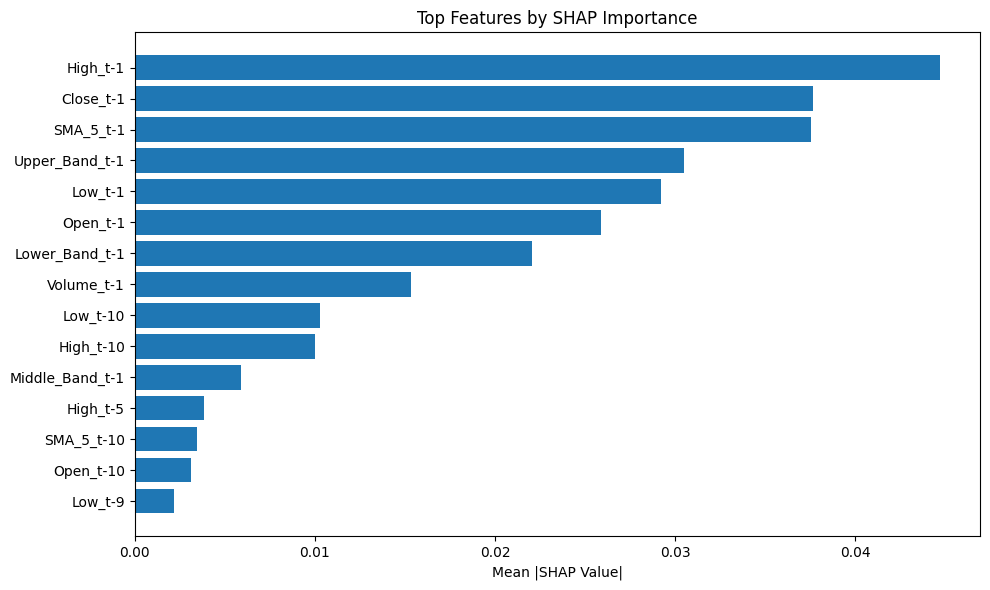


=== LIME Analysis ===
Creating LIME explainer...
Generating LIME explanations for 5 samples...

=== Temporal Importance Analysis ===


<Figure size 1200x800 with 0 Axes>

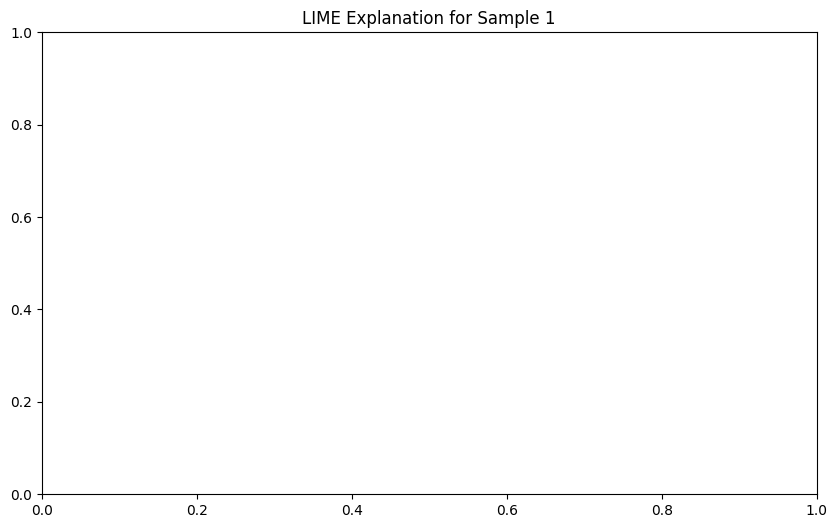

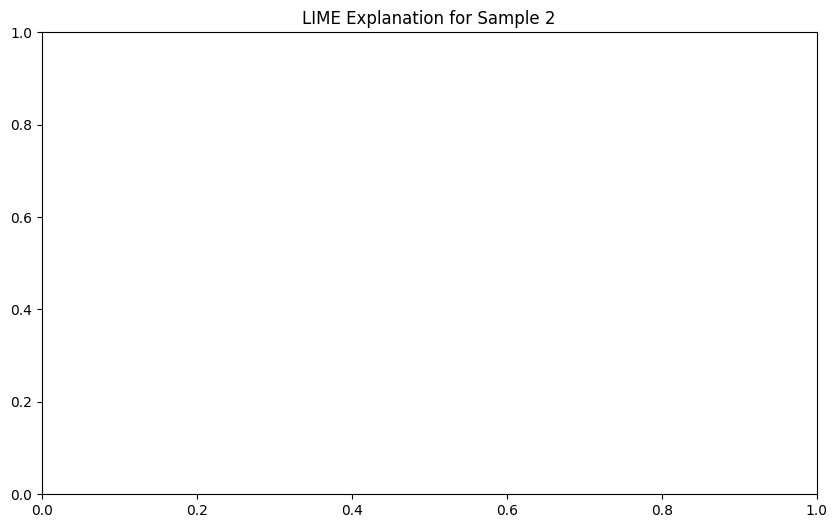

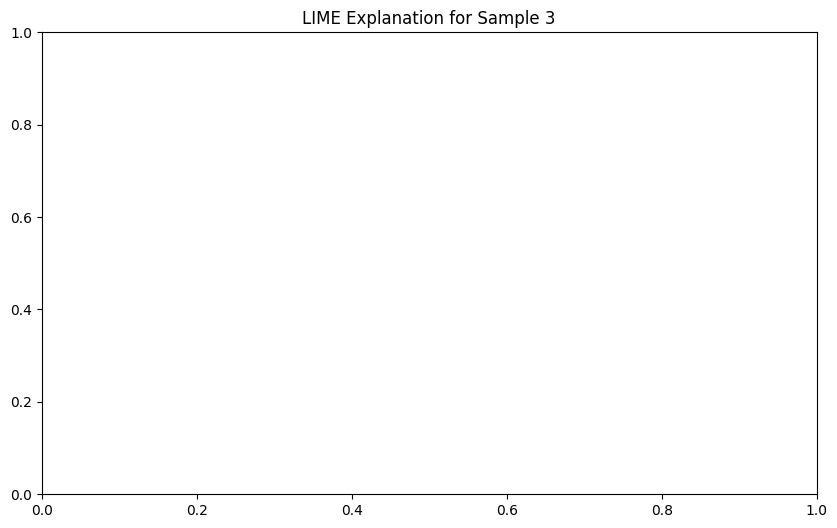

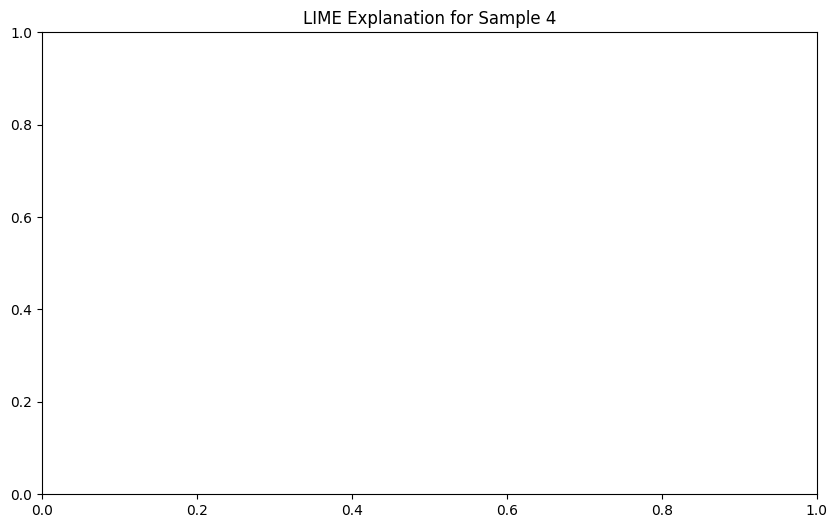

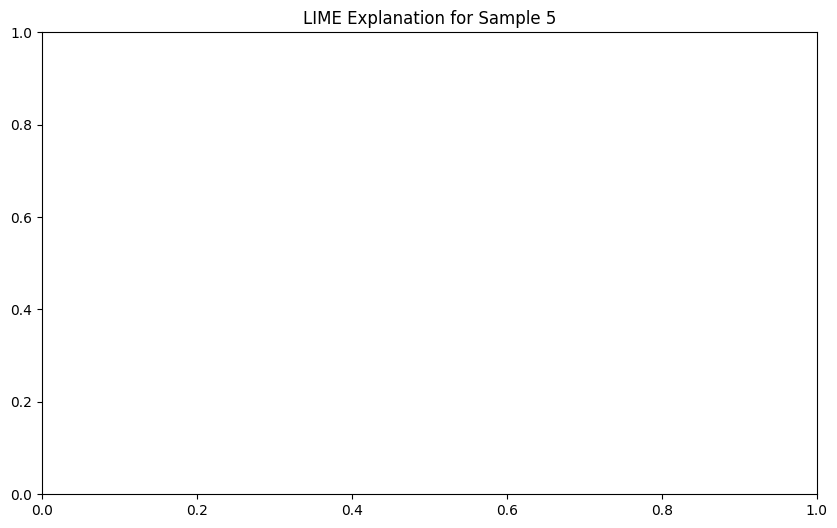

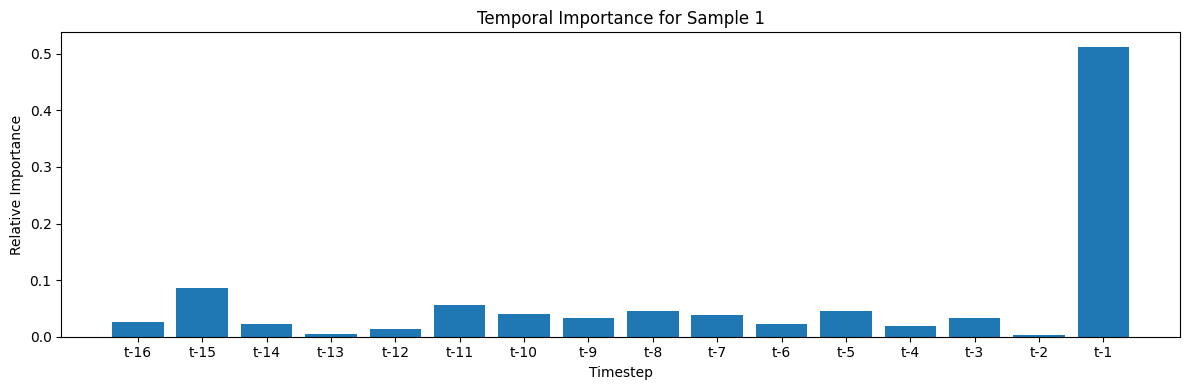

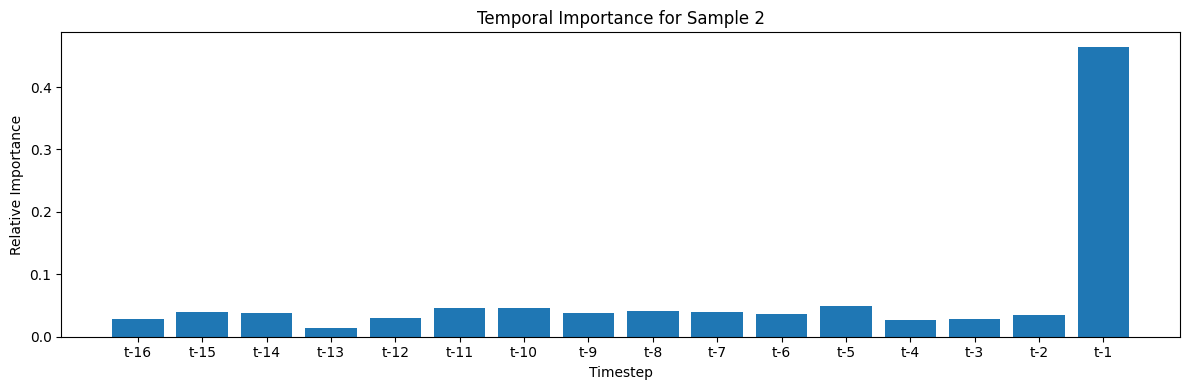

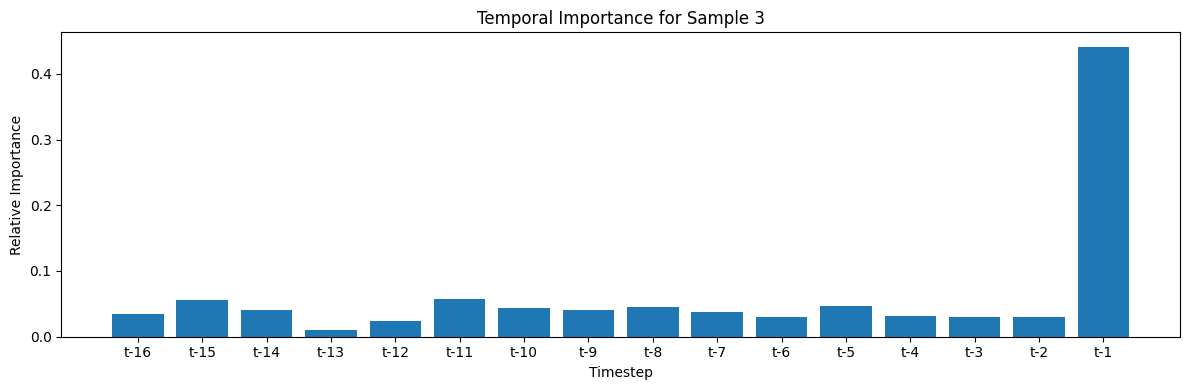

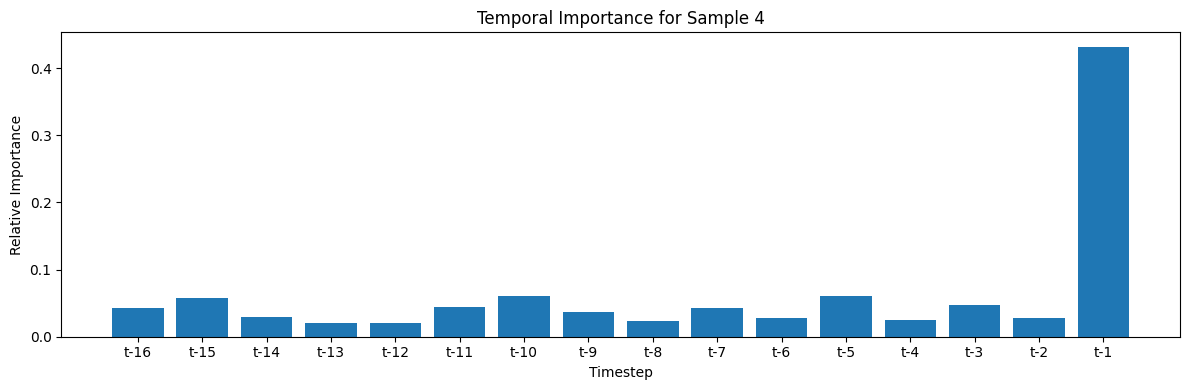

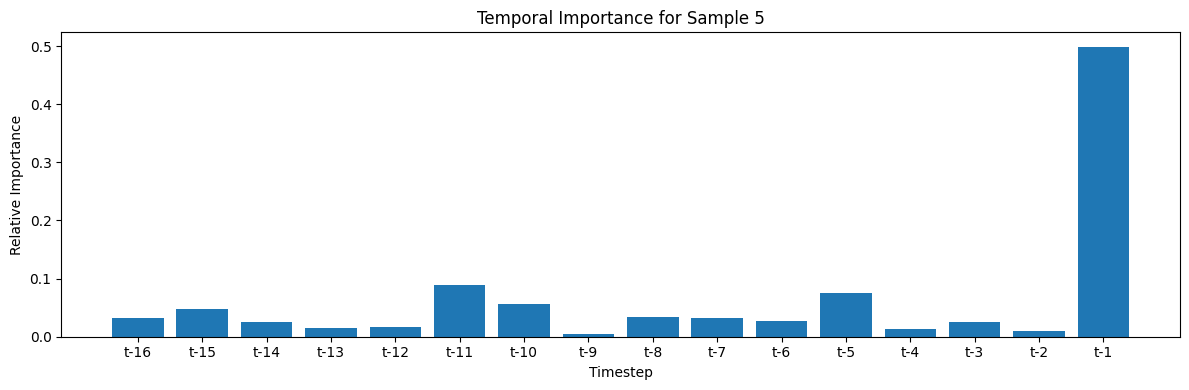

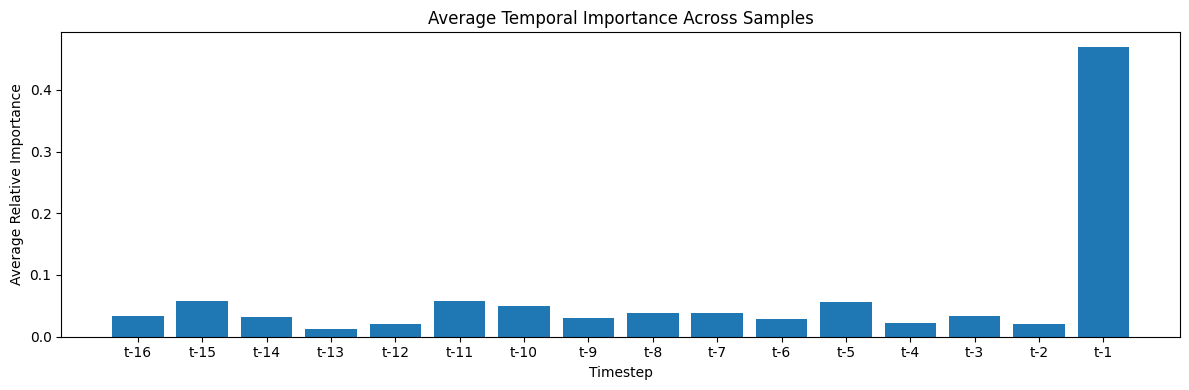


Yorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.

En önemli 10 özellik (SHAP):
            Feature  Importance
211        High_t-1    0.044681
210       Close_t-1    0.037666
215       SMA_5_t-1    0.037554
220  Upper_Band_t-1    0.030503
212         Low_t-1    0.029224
213        Open_t-1    0.025879
222  Lower_Band_t-1    0.022045
214      Volume_t-1    0.015312
86         Low_t-10    0.010265
85        High_t-10    0.010018


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from reformer_pytorch import Reformer
from google.colab import drive
import time
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])

drive.mount('/content/drive')

class ReformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, depth, heads, bucket_size, n_hashes, output_dim=1):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, bucket_size * 2, d_model))

        self.input_dropout = nn.Dropout(0.1)

        self.reformer = Reformer(
            dim=d_model,
            depth=depth,
            heads=heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=True
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoding
        x = self.input_dropout(x)
        x = self.reformer(x)
        x = self.layer_norm(x)
        x = x[:, -1, :]
        x = self.fc_out(x)
        return x

def prepare_features_for_interpretability(X, features):
    """
    Prepare feature names for interpretability methods with time series data

    Args:
        X: Input data with shape (samples, seq_length, features)
        features: List of feature names

    Returns:
        X_reshaped: Reshaped data with shape (samples, seq_length*features)
        feature_names: Expanded list of feature names including timesteps
    """
    seq_length = X.shape[1]
    feature_names = []

    for t in range(seq_length):
        for f in features:
            feature_names.append(f"{f}_t-{seq_length-t}")


    X_reshaped = X.reshape(X.shape[0], -1)

    return X_reshaped, feature_names

def explain_with_shap(model, X_train, X_test, features, device, num_background=20, num_samples=5):
    """
    Generate SHAP explanations for the transformer model with error handling
    """
    model.eval()


    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)


    background = X_train_reshaped[:num_background]


    def model_predict(x):
      batch_size = x.shape[0]
      x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
      x_tensor = torch.FloatTensor(x_reshaped).to(device)  # Use the GPU


      sub_batch_size = 1
      outputs = []

      for i in range(0, batch_size, sub_batch_size):
          sub_batch = x_tensor[i:i+sub_batch_size]
          with torch.no_grad():
              sub_output = model(sub_batch)
          outputs.append(sub_output.cpu().numpy())

      return np.concatenate(outputs, axis=0)


    print("Creating SHAP explainer...")

    explainer = shap.KernelExplainer(model_predict, background)


    samples_to_explain = X_test_reshaped[:num_samples]

    print(f"Calculating SHAP values for {num_samples} samples...")

    shap_values = explainer.shap_values(samples_to_explain)


    if isinstance(shap_values, list):
        shap_values_for_importance = shap_values[0] if isinstance(shap_values, list) else shap_values
    else:
        shap_values_for_importance = shap_values

    if len(shap_values_for_importance.shape) > 2:
        shap_values_for_importance = shap_values_for_importance.reshape(shap_values_for_importance.shape[0], -1)

    feature_importance = np.abs(shap_values_for_importance).mean(0)

    if len(feature_names) != len(feature_importance):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importance array length ({len(feature_importance)})")
        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_names = feature_names + [f"Unknown_{i}" for i in range(len(feature_importance) - len(feature_names))]

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    top_n = 15
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(12, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Ortalama |SHAP Değeri|')
    plt.title(f'En Önemli {top_n} Özellik (SHAP)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    feature_importance_df.to_csv(f'{result_dir}/shap_feature_importance.csv')

    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, samples_to_explain, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{result_dir}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating SHAP summary plot: {e}")

    return {
        'shap_values': shap_values,
        'feature_importance': feature_importance_df
    }

def explain_with_lime(model, X_train, X_test, features, device, num_samples=2):
    """
    Generate LIME explanations for the transformer model
    """
    model_cpu = model.to('cpu')
    model_cpu.eval()

    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)

    def predict_fn(x):
        batch_size = x.shape[0]
        x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
        x_tensor = torch.FloatTensor(x_reshaped)

        with torch.no_grad():
            output = model_cpu(x_tensor)
        return output.numpy()

    print("Creating LIME explainer...")
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_reshaped,
        feature_names=feature_names,
        discretize_continuous=True,
        mode='regression'
    )

    print(f"Generating LIME explanations for {num_samples} samples...")
    explanations = []

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    for i in range(min(num_samples, len(X_test_reshaped))):
        try:
            exp = explainer.explain_instance(
                X_test_reshaped[i],
                predict_fn,
                num_features=20
            )
            explanations.append(exp)

            plt.figure(figsize=(10, 6))
            plt.title(f'LIME Explanation for Sample {i+1}')
            exp.as_pyplot_figure()
            plt.tight_layout()

            plt.savefig(f'{result_dir}/lime_explanation_sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            print(f"Error explaining sample {i}: {e}")

    model.to(device)

    return explanations

def analyze_temporal_importance(model, X_test, features, device, num_samples=5):
    """
    Analyze how each timestep contributes to the prediction

    Args:
        model: Trained PyTorch model
        X_test: Test data
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')
        num_samples: Number of samples to analyze
    """
    model.eval()

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    all_importances = []

    for sample_idx in range(min(num_samples, len(X_test))):
        sequence = X_test[sample_idx:sample_idx+1]
        sequence_tensor = torch.FloatTensor(sequence).to(device)

        with torch.no_grad():
            original_pred = model(sequence_tensor).item()

        importances = np.zeros(sequence.shape[1])
        for t in range(sequence.shape[1]):
            masked = sequence.copy()
            masked[0, t, :] = 0
            masked_tensor = torch.FloatTensor(masked).to(device)

            with torch.no_grad():
                masked_pred = model(masked_tensor).item()

            importances[t] = abs(original_pred - masked_pred)

        importances = importances / importances.sum() if importances.sum() > 0 else importances
        all_importances.append(importances)

        plt.figure(figsize=(12, 4))
        plt.bar(range(sequence.shape[1]), importances)
        plt.xlabel('Timestep')
        plt.ylabel('Relative Importance')
        plt.title(f'Temporal Importance for Sample {sample_idx+1}')
        plt.xticks(range(sequence.shape[1]), [f't-{sequence.shape[1]-i}' for i in range(sequence.shape[1])])
        plt.tight_layout()

        plt.savefig(f'{result_dir}/temporal_importance_sample_{sample_idx+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

    avg_importance = np.mean(all_importances, axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(avg_importance)), avg_importance)
    plt.xlabel('Timestep')
    plt.ylabel('Average Relative Importance')
    plt.title('Average Temporal Importance Across Samples')
    plt.xticks(range(len(avg_importance)), [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))])
    plt.tight_layout()

    plt.savefig(f'{result_dir}/average_temporal_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame({
        'Timestep': [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))],
        'Importance': avg_importance
    }).to_csv(f'{result_dir}/temporal_importance.csv', index=False)

def run_interpretability_analysis(model, X_train, X_test, features, device):
    """
    Run comprehensive interpretability analysis on the model

    Args:
        model: Trained PyTorch model
        X_train: Training data with shape (samples, seq_length, features)
        X_test: Test data with shape (samples, seq_length, features)
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')

    Returns:
        Dictionary with results of the analysis
    """
    print("Starting model interpretability analysis...")

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    print(f"Results will be saved to: {result_dir}")

    print("\n=== SHAP Analysis ===")
    shap_results = explain_with_shap(model, X_train, X_test, features, device)

    print("\n=== LIME Analysis ===")
    lime_results = explain_with_lime(model, X_train, X_test, features, device)

    print("\n=== Temporal Importance Analysis ===")
    analyze_temporal_importance(model, X_test, features, device)

    return {
        'shap_results': shap_results,
        'lime_results': lime_results
    }

def prepare_sequences(data, bucket_size=8):
    """Sekans hazırlama fonksiyonu"""
    seq_length = bucket_size * 2
    xs = []
    ys = []

    close_index = 0

    for i in range(0, len(data) - seq_length - 1, 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length, close_index:close_index+1]
        if len(x) == seq_length:
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)

class FinancialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def interpret_existing_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    drive.mount('/content/drive')

    features = [
        'Close',
        'High',
        'Low',
        'Open',
        'Volume',
        'SMA_5',
        'SMA_10',
        'SMA_20',
        'SMA_50',
        'RSI_14',
        'Upper_Band',
        'Middle_Band',
        'Lower_Band',
        'MACD',
    ]

    bucket_size = 8
    seq_length = bucket_size * 2

    model_params = {
        'input_dim': len(features),
        'd_model': 32,
        'depth': 1,
        'heads': 2,
        'bucket_size': bucket_size,
        'n_hashes': 2,
        'output_dim': 1
    }

    try:
        dosya_yolu = '/content/drive/MyDrive/ders/VAKBN.IS.csv'
        df = pd.read_csv(dosya_yolu)

        close_scaler = MinMaxScaler()
        df['Close_scaled'] = close_scaler.fit_transform(df[['Close']])

        other_features = [f for f in features if f != 'Close']
        scaled_features = {}
        for feature in other_features:
            scaler = MinMaxScaler()
            df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])
            scaled_features[feature] = scaler

        scaled_columns = [f'{f}_scaled' for f in features]
        scaled_data = df[scaled_columns].values

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]


        X_train, y_train = prepare_sequences(train_data, bucket_size)
        X_test, y_test = prepare_sequences(test_data, bucket_size)

        print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
        print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

        model = ReformerTimeSeries(**model_params).to(device)

        model_path = '/content/drive/MyDrive/ders/model.pth'
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Model weights loaded from: {model_path}")
        else:
            model.load_state_dict(checkpoint)
            print(f"Model (direct state_dict) loaded from: {model_path}")

        model.eval()

        print("\nModel yorumlanıyor...")
        interpretability_results = run_interpretability_analysis(
            model=model,
            X_train=X_train,
            X_test=X_test,
            features=features,
            device=device
        )

        print("\nYorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.")
        print("\nEn önemli 10 özellik (SHAP):")
        print(interpretability_results['shap_results']['feature_importance'].head(10))

    except Exception as e:
        print(f"Bir hata oluştu: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    interpret_existing_model()

# **TSKB BANK**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shapes - X: (2907, 16, 14), y: (2907, 1)
Test shapes - X: (714, 16, 14), y: (714, 1)
Model (direct state_dict) loaded from: /content/drive/MyDrive/ders/model.pth

Model yorumlanıyor...
Starting model interpretability analysis...
Results will be saved to: /content/drive/MyDrive/ders/model_interpretability

=== SHAP Analysis ===
Creating SHAP explainer...
Calculating SHAP values for 5 samples...


  0%|          | 0/5 [00:00<?, ?it/s]

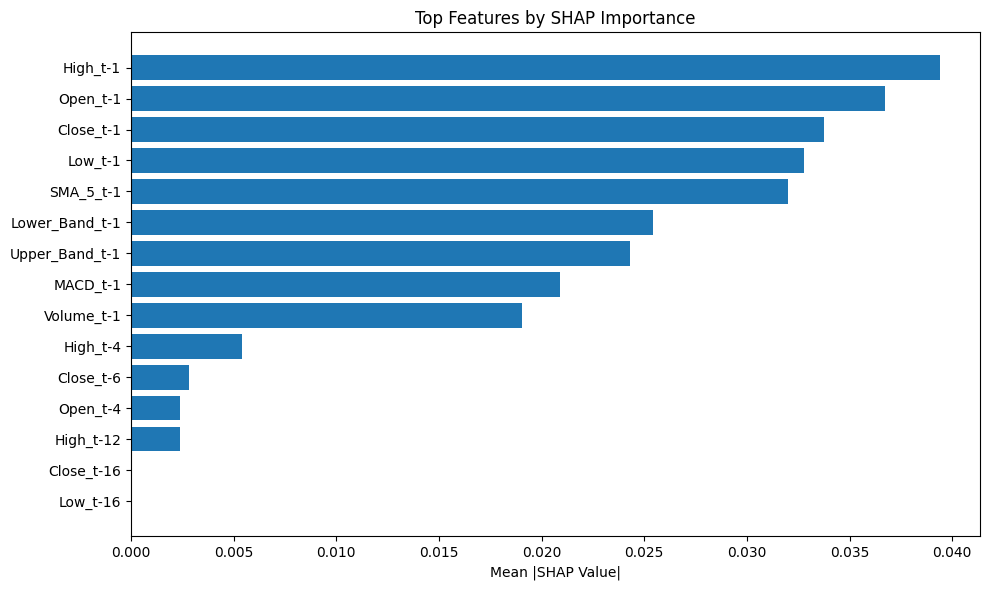


=== LIME Analysis ===
Creating LIME explainer...
Generating LIME explanations for 5 samples...

=== Temporal Importance Analysis ===


<Figure size 1200x800 with 0 Axes>

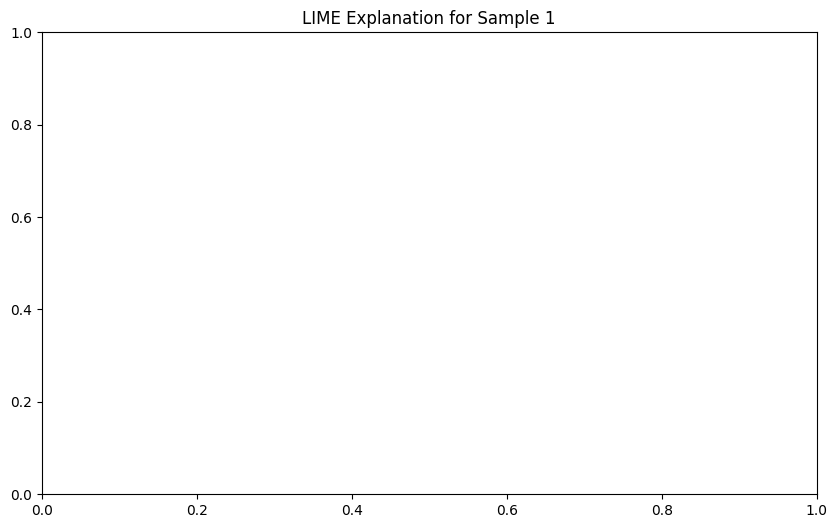

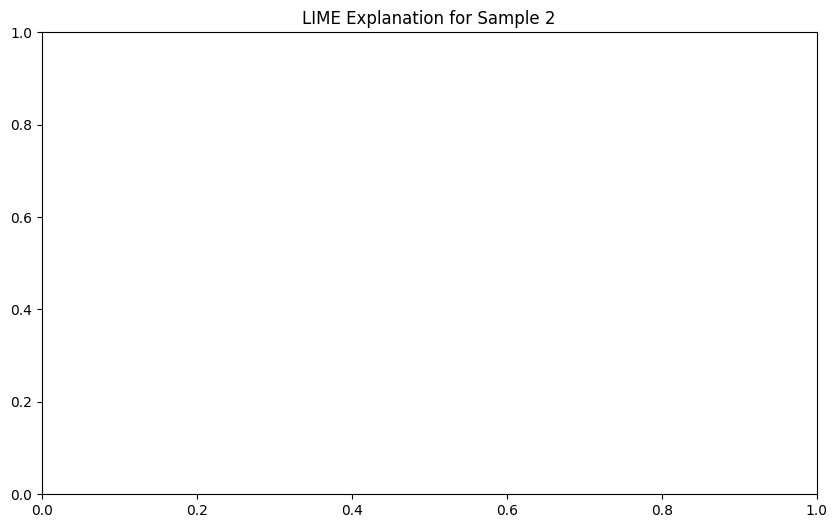

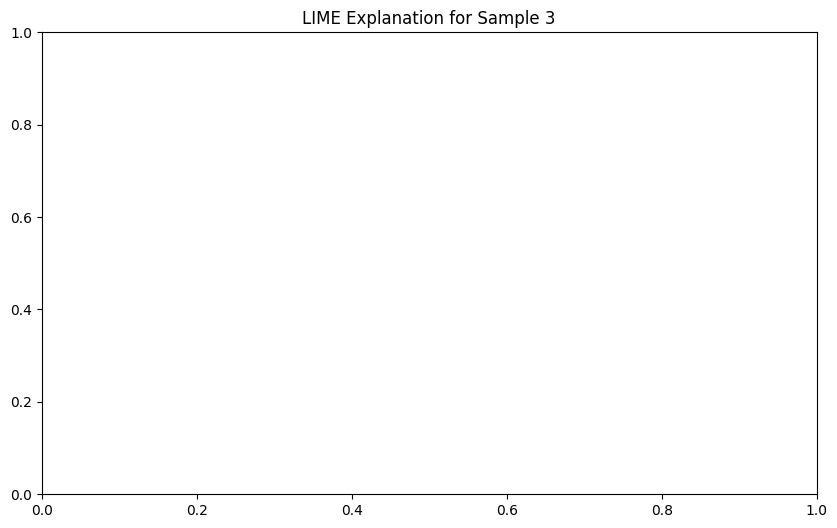

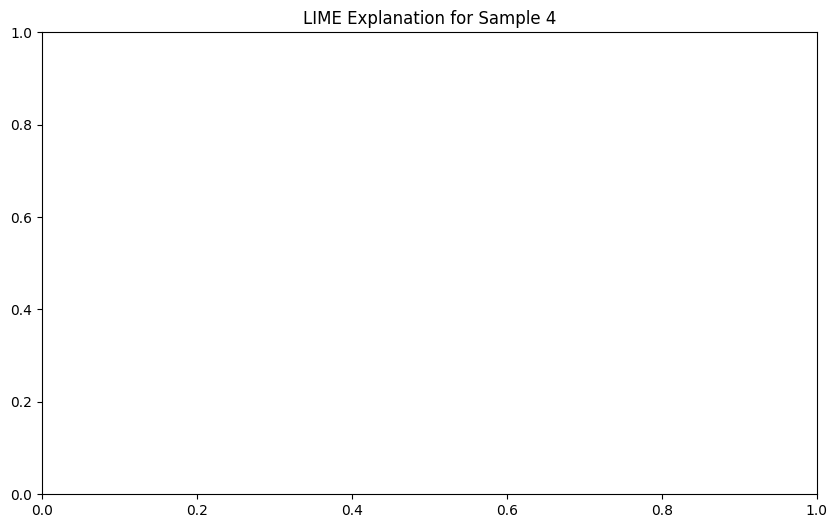

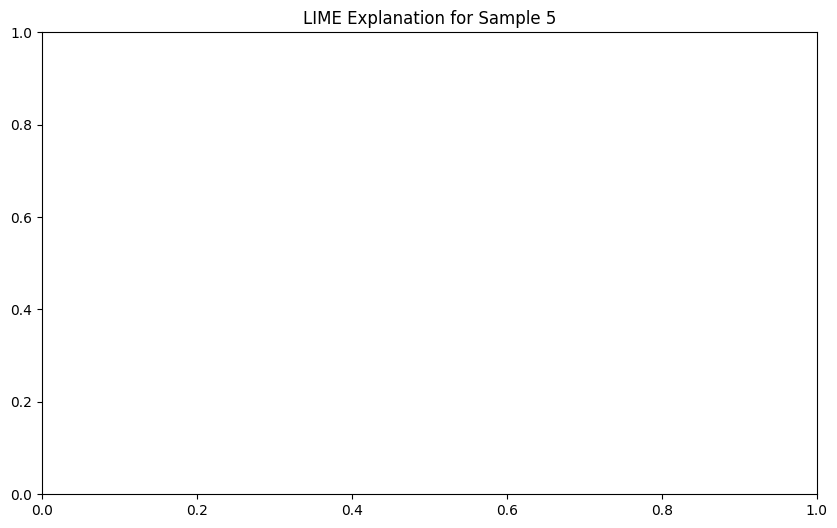

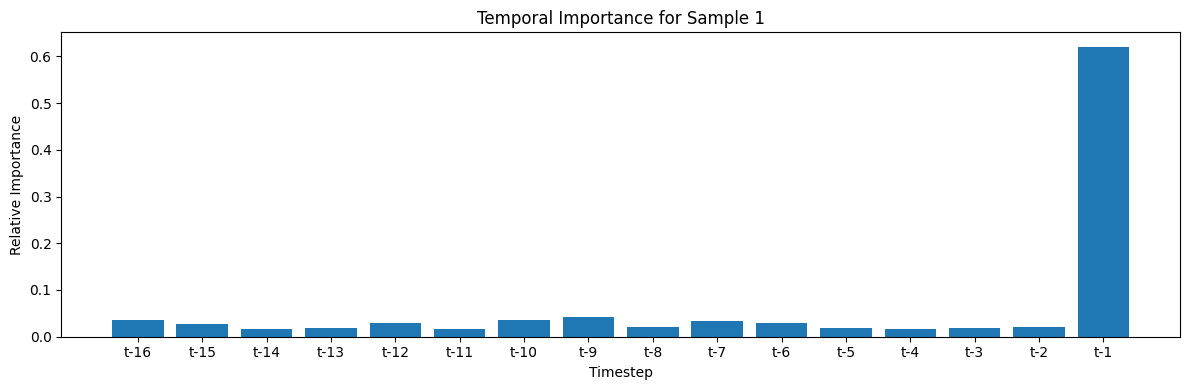

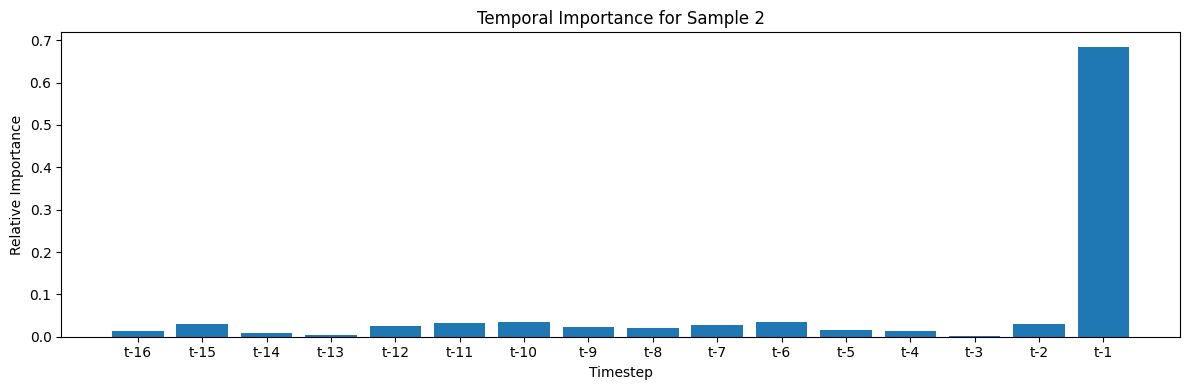

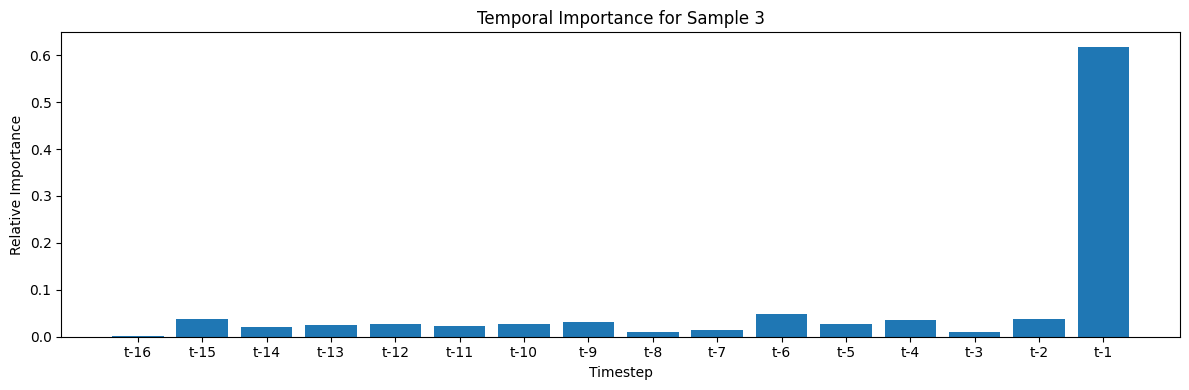

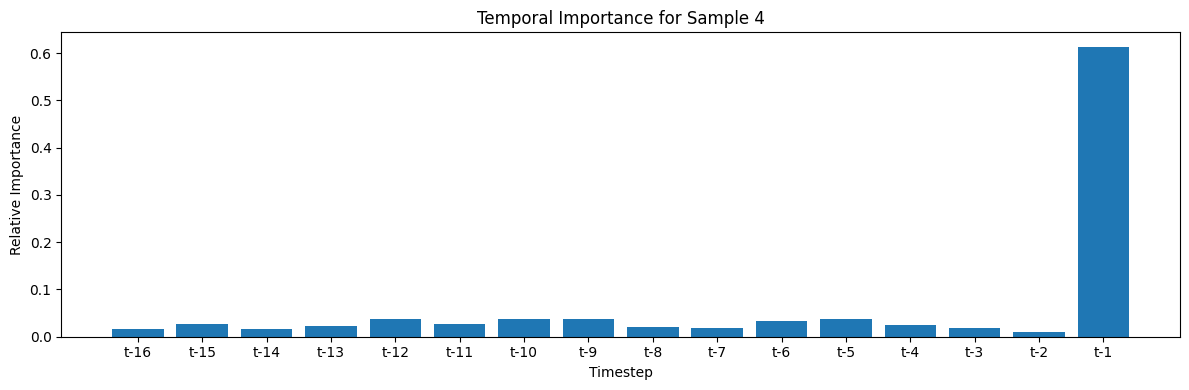

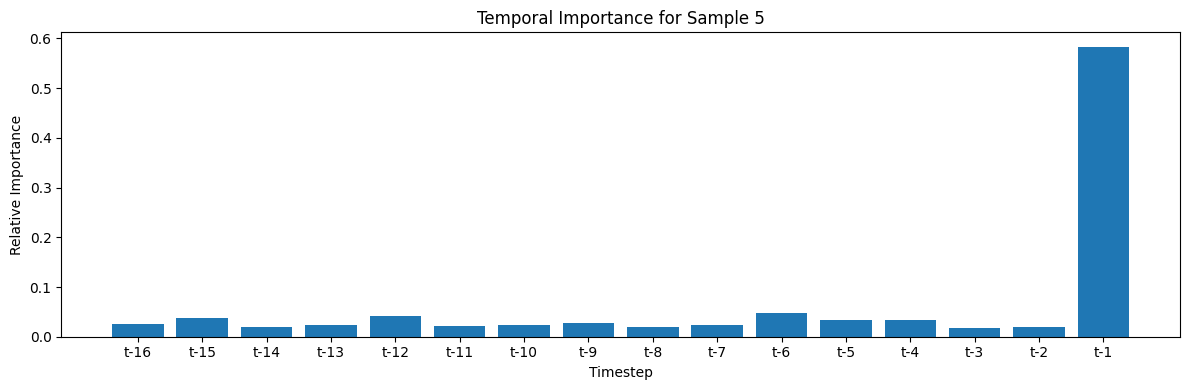

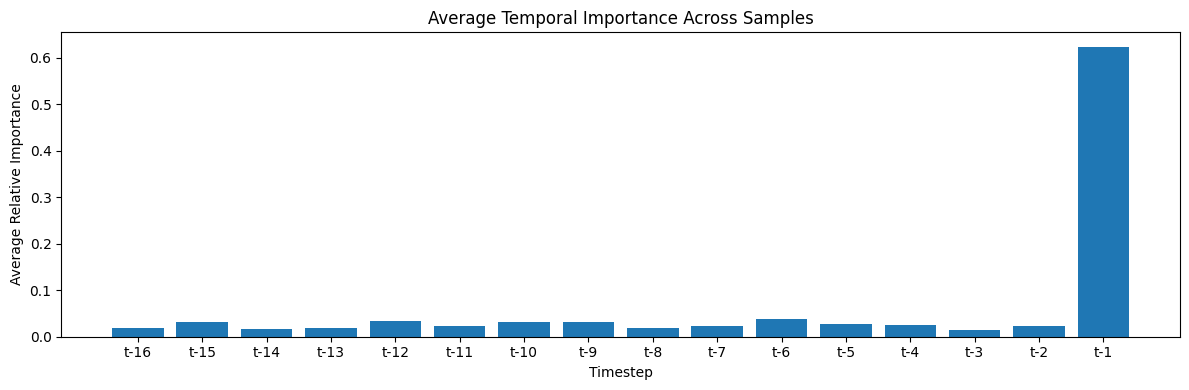


Yorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.

En önemli 10 özellik (SHAP):
            Feature  Importance
211        High_t-1    0.039386
213        Open_t-1    0.036736
210       Close_t-1    0.033734
212         Low_t-1    0.032806
215       SMA_5_t-1    0.032009
222  Lower_Band_t-1    0.025404
220  Upper_Band_t-1    0.024312
223        MACD_t-1    0.020889
214      Volume_t-1    0.019029
169        High_t-4    0.005420


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from reformer_pytorch import Reformer
from google.colab import drive
import time
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])

drive.mount('/content/drive')

class ReformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, depth, heads, bucket_size, n_hashes, output_dim=1):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, bucket_size * 2, d_model))

        self.input_dropout = nn.Dropout(0.1)

        self.reformer = Reformer(
            dim=d_model,
            depth=depth,
            heads=heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=True
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoding
        x = self.input_dropout(x)
        x = self.reformer(x)
        x = self.layer_norm(x)
        x = x[:, -1, :]
        x = self.fc_out(x)
        return x

def prepare_features_for_interpretability(X, features):
    """
    Prepare feature names for interpretability methods with time series data

    Args:
        X: Input data with shape (samples, seq_length, features)
        features: List of feature names

    Returns:
        X_reshaped: Reshaped data with shape (samples, seq_length*features)
        feature_names: Expanded list of feature names including timesteps
    """
    seq_length = X.shape[1]
    feature_names = []

    for t in range(seq_length):
        for f in features:
            feature_names.append(f"{f}_t-{seq_length-t}")


    X_reshaped = X.reshape(X.shape[0], -1)

    return X_reshaped, feature_names

def explain_with_shap(model, X_train, X_test, features, device, num_background=20, num_samples=5):
    """
    Generate SHAP explanations for the transformer model with error handling
    """
    model.eval()


    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)


    background = X_train_reshaped[:num_background]


    def model_predict(x):
      batch_size = x.shape[0]
      x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
      x_tensor = torch.FloatTensor(x_reshaped).to(device)  # Use the GPU


      sub_batch_size = 1
      outputs = []

      for i in range(0, batch_size, sub_batch_size):
          sub_batch = x_tensor[i:i+sub_batch_size]
          with torch.no_grad():
              sub_output = model(sub_batch)
          outputs.append(sub_output.cpu().numpy())

      return np.concatenate(outputs, axis=0)


    print("Creating SHAP explainer...")

    explainer = shap.KernelExplainer(model_predict, background)


    samples_to_explain = X_test_reshaped[:num_samples]

    print(f"Calculating SHAP values for {num_samples} samples...")

    shap_values = explainer.shap_values(samples_to_explain)


    if isinstance(shap_values, list):
        shap_values_for_importance = shap_values[0] if isinstance(shap_values, list) else shap_values
    else:
        shap_values_for_importance = shap_values

    if len(shap_values_for_importance.shape) > 2:
        shap_values_for_importance = shap_values_for_importance.reshape(shap_values_for_importance.shape[0], -1)

    feature_importance = np.abs(shap_values_for_importance).mean(0)

    if len(feature_names) != len(feature_importance):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importance array length ({len(feature_importance)})")
        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_names = feature_names + [f"Unknown_{i}" for i in range(len(feature_importance) - len(feature_names))]

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    top_n = 15
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(12, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Ortalama |SHAP Değeri|')
    plt.title(f'En Önemli {top_n} Özellik (SHAP)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    feature_importance_df.to_csv(f'{result_dir}/shap_feature_importance.csv')

    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, samples_to_explain, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{result_dir}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating SHAP summary plot: {e}")

    return {
        'shap_values': shap_values,
        'feature_importance': feature_importance_df
    }

def explain_with_lime(model, X_train, X_test, features, device, num_samples=5):
    """
    Generate LIME explanations for the transformer model
    """
    model_cpu = model.to('cpu')
    model_cpu.eval()

    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)

    def predict_fn(x):
        batch_size = x.shape[0]
        x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
        x_tensor = torch.FloatTensor(x_reshaped)

        with torch.no_grad():
            output = model_cpu(x_tensor)
        return output.numpy()

    print("Creating LIME explainer...")
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_reshaped,
        feature_names=feature_names,
        discretize_continuous=True,
        mode='regression'
    )

    print(f"Generating LIME explanations for {num_samples} samples...")
    explanations = []

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    for i in range(min(num_samples, len(X_test_reshaped))):
        try:
            exp = explainer.explain_instance(
                X_test_reshaped[i],
                predict_fn,
                num_features=20
            )
            explanations.append(exp)

            plt.figure(figsize=(10, 6))
            plt.title(f'LIME Explanation for Sample {i+1}')
            exp.as_pyplot_figure()
            plt.tight_layout()

            plt.savefig(f'{result_dir}/lime_explanation_sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            print(f"Error explaining sample {i}: {e}")

    model.to(device)

    return explanations

def analyze_temporal_importance(model, X_test, features, device, num_samples=2):
    """
    Analyze how each timestep contributes to the prediction

    Args:
        model: Trained PyTorch model
        X_test: Test data
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')
        num_samples: Number of samples to analyze
    """
    model.eval()

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    all_importances = []

    for sample_idx in range(min(num_samples, len(X_test))):
        sequence = X_test[sample_idx:sample_idx+1]
        sequence_tensor = torch.FloatTensor(sequence).to(device)

        with torch.no_grad():
            original_pred = model(sequence_tensor).item()

        importances = np.zeros(sequence.shape[1])
        for t in range(sequence.shape[1]):
            masked = sequence.copy()
            masked[0, t, :] = 0
            masked_tensor = torch.FloatTensor(masked).to(device)

            with torch.no_grad():
                masked_pred = model(masked_tensor).item()

            importances[t] = abs(original_pred - masked_pred)

        importances = importances / importances.sum() if importances.sum() > 0 else importances
        all_importances.append(importances)

        plt.figure(figsize=(12, 4))
        plt.bar(range(sequence.shape[1]), importances)
        plt.xlabel('Timestep')
        plt.ylabel('Relative Importance')
        plt.title(f'Temporal Importance for Sample {sample_idx+1}')
        plt.xticks(range(sequence.shape[1]), [f't-{sequence.shape[1]-i}' for i in range(sequence.shape[1])])
        plt.tight_layout()

        plt.savefig(f'{result_dir}/temporal_importance_sample_{sample_idx+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

    avg_importance = np.mean(all_importances, axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(avg_importance)), avg_importance)
    plt.xlabel('Timestep')
    plt.ylabel('Average Relative Importance')
    plt.title('Average Temporal Importance Across Samples')
    plt.xticks(range(len(avg_importance)), [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))])
    plt.tight_layout()

    plt.savefig(f'{result_dir}/average_temporal_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame({
        'Timestep': [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))],
        'Importance': avg_importance
    }).to_csv(f'{result_dir}/temporal_importance.csv', index=False)

def run_interpretability_analysis(model, X_train, X_test, features, device):
    """
    Run comprehensive interpretability analysis on the model

    Args:
        model: Trained PyTorch model
        X_train: Training data with shape (samples, seq_length, features)
        X_test: Test data with shape (samples, seq_length, features)
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')

    Returns:
        Dictionary with results of the analysis
    """
    print("Starting model interpretability analysis...")

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    print(f"Results will be saved to: {result_dir}")

    print("\n=== SHAP Analysis ===")
    shap_results = explain_with_shap(model, X_train, X_test, features, device)

    print("\n=== LIME Analysis ===")
    lime_results = explain_with_lime(model, X_train, X_test, features, device)

    print("\n=== Temporal Importance Analysis ===")
    analyze_temporal_importance(model, X_test, features, device)

    return {
        'shap_results': shap_results,
        'lime_results': lime_results
    }

def prepare_sequences(data, bucket_size=8):
    """Sekans hazırlama fonksiyonu"""
    seq_length = bucket_size * 2
    xs = []
    ys = []

    close_index = 0

    for i in range(0, len(data) - seq_length - 1, 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length, close_index:close_index+1]
        if len(x) == seq_length:
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)

class FinancialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def interpret_existing_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    drive.mount('/content/drive')

    features = [
        'Close',
        'High',
        'Low',
        'Open',
        'Volume',
        'SMA_5',
        'SMA_10',
        'SMA_20',
        'SMA_50',
        'RSI_14',
        'Upper_Band',
        'Middle_Band',
        'Lower_Band',
        'MACD',
    ]

    bucket_size = 8
    seq_length = bucket_size * 2

    model_params = {
        'input_dim': len(features),
        'd_model': 32,
        'depth': 1,
        'heads': 2,
        'bucket_size': bucket_size,
        'n_hashes': 2,
        'output_dim': 1
    }

    try:
        dosya_yolu = '/content/drive/MyDrive/ders/TSKB.IS.csv'
        df = pd.read_csv(dosya_yolu)

        close_scaler = MinMaxScaler()
        df['Close_scaled'] = close_scaler.fit_transform(df[['Close']])

        other_features = [f for f in features if f != 'Close']
        scaled_features = {}
        for feature in other_features:
            scaler = MinMaxScaler()
            df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])
            scaled_features[feature] = scaler

        scaled_columns = [f'{f}_scaled' for f in features]
        scaled_data = df[scaled_columns].values

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]


        X_train, y_train = prepare_sequences(train_data, bucket_size)
        X_test, y_test = prepare_sequences(test_data, bucket_size)

        print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
        print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

        model = ReformerTimeSeries(**model_params).to(device)

        model_path = '/content/drive/MyDrive/ders/model.pth'
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Model weights loaded from: {model_path}")
        else:
            model.load_state_dict(checkpoint)
            print(f"Model (direct state_dict) loaded from: {model_path}")

        model.eval()

        print("\nModel yorumlanıyor...")
        interpretability_results = run_interpretability_analysis(
            model=model,
            X_train=X_train,
            X_test=X_test,
            features=features,
            device=device
        )

        print("\nYorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.")
        print("\nEn önemli 10 özellik (SHAP):")
        print(interpretability_results['shap_results']['feature_importance'].head(10))

    except Exception as e:
        print(f"Bir hata oluştu: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    interpret_existing_model()

# **ŞEKER BANK XAI**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shapes - X: (2907, 16, 14), y: (2907, 1)
Test shapes - X: (714, 16, 14), y: (714, 1)
Model (direct state_dict) loaded from: /content/drive/MyDrive/ders/model.pth

Model yorumlanıyor...
Starting model interpretability analysis...
Results will be saved to: /content/drive/MyDrive/ders/model_interpretability

=== SHAP Analysis ===
Creating SHAP explainer...
Calculating SHAP values for 5 samples...


  0%|          | 0/5 [00:00<?, ?it/s]

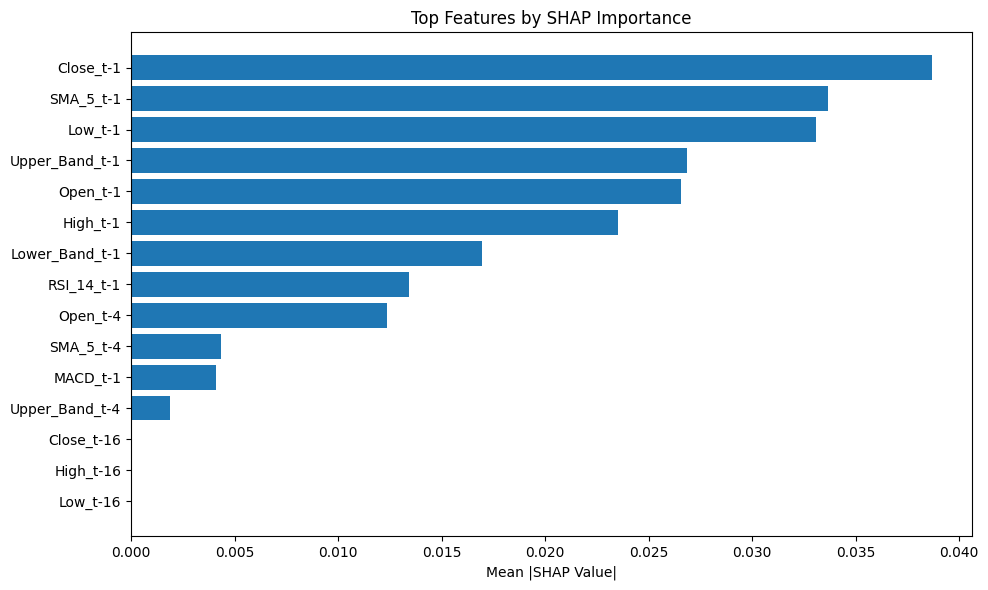


=== LIME Analysis ===
Creating LIME explainer...
Generating LIME explanations for 5 samples...

=== Temporal Importance Analysis ===


<Figure size 1200x800 with 0 Axes>

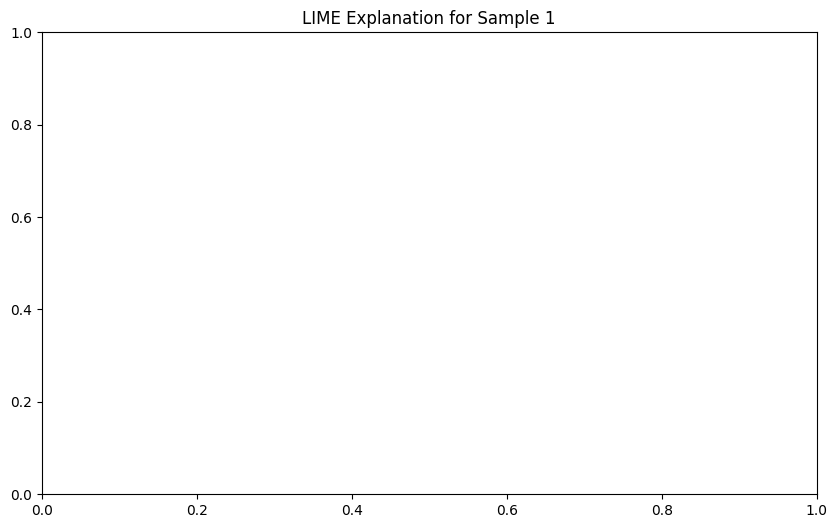

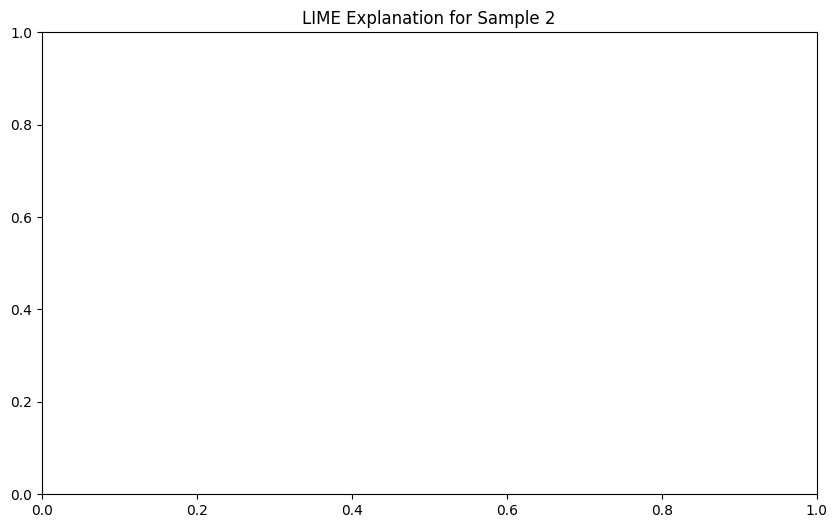

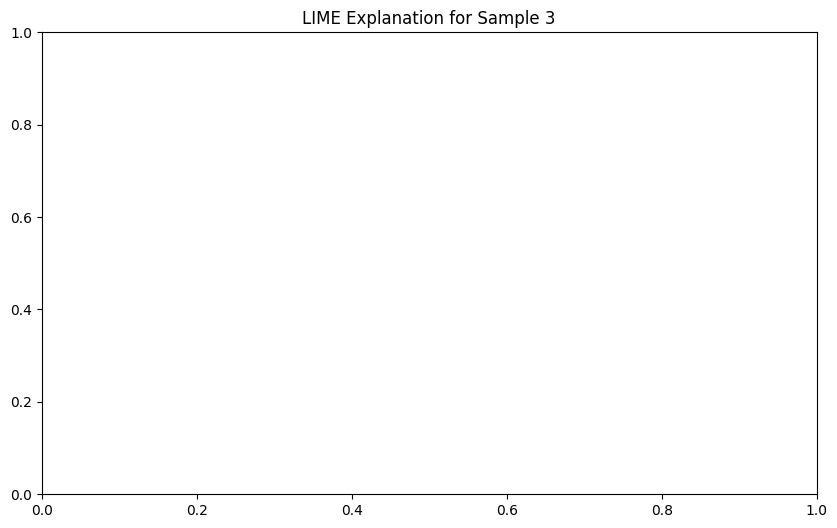

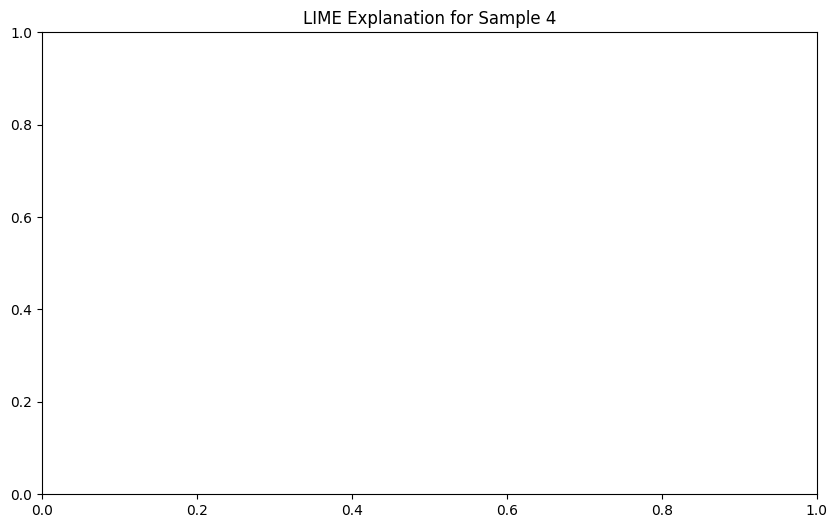

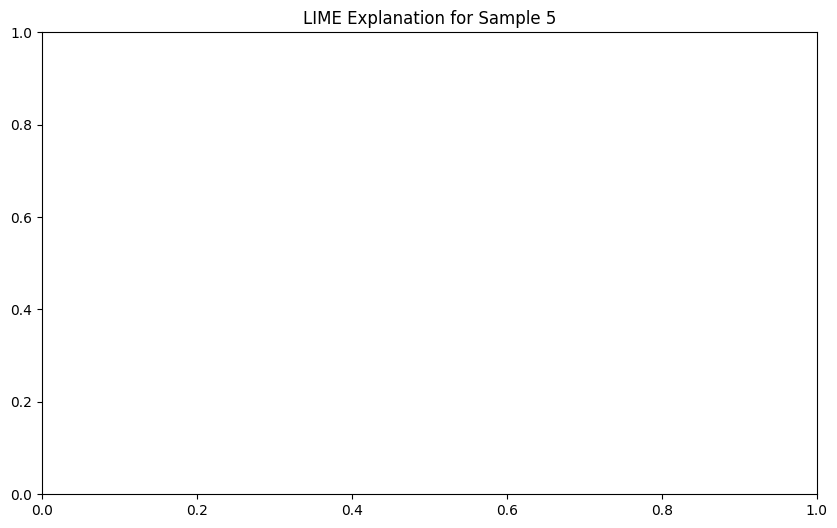

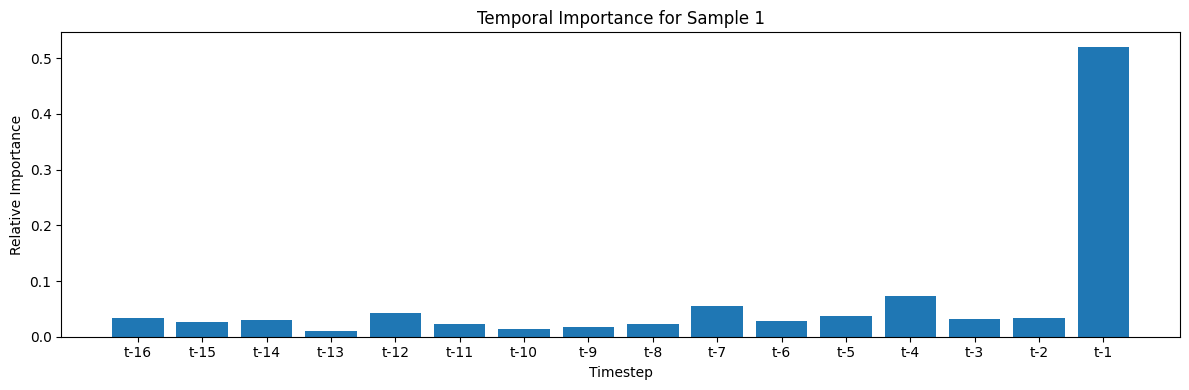

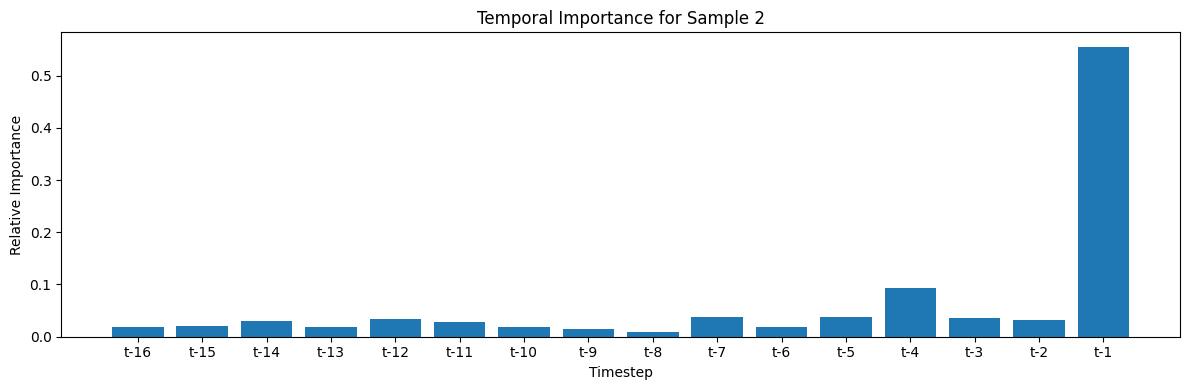

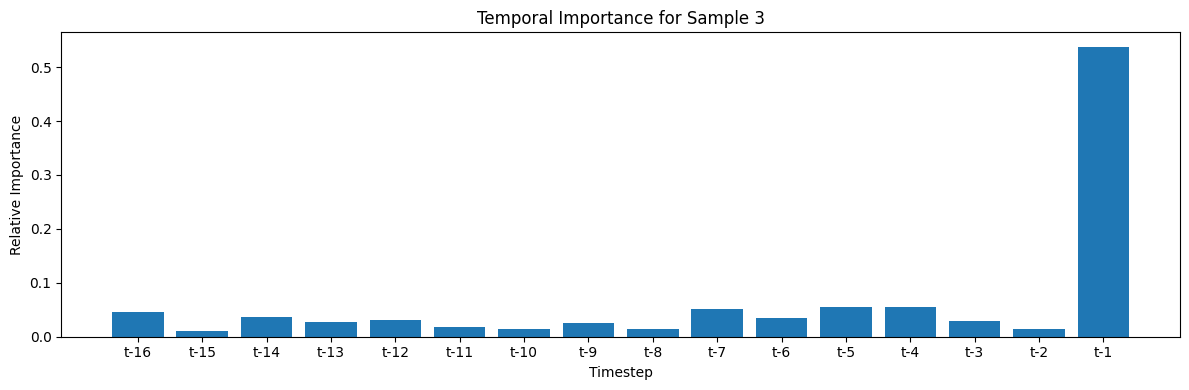

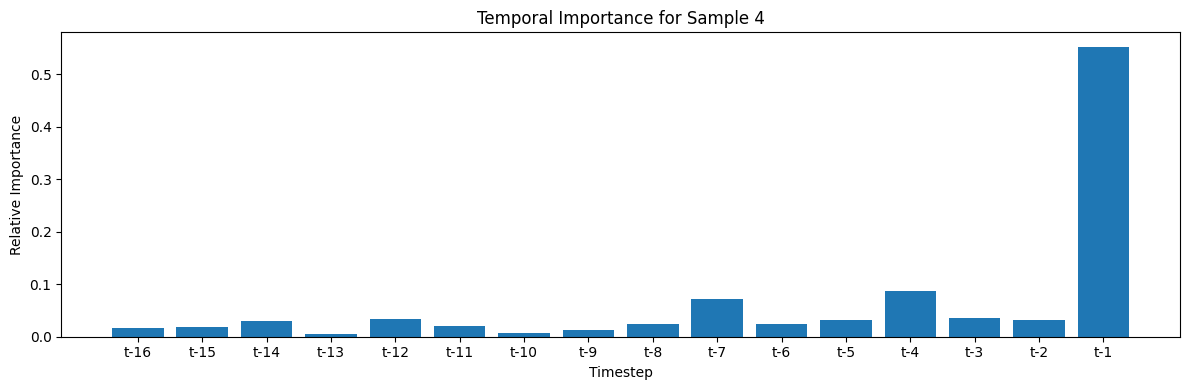

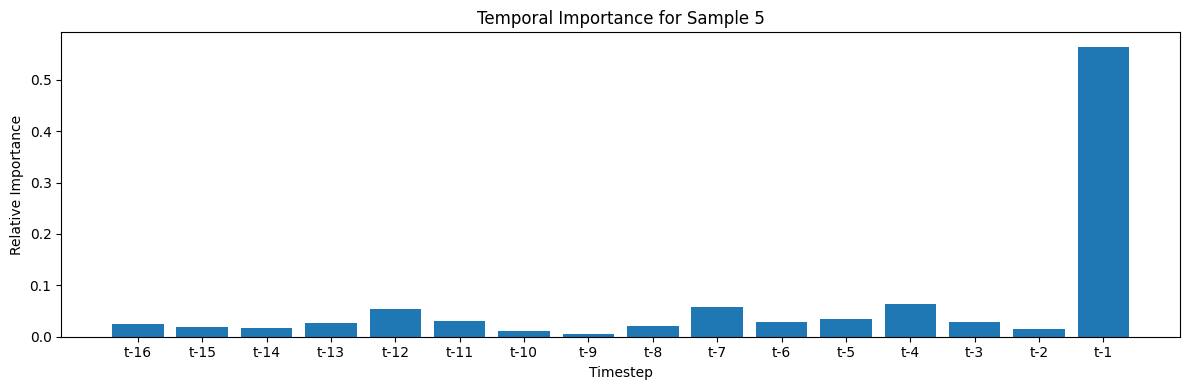

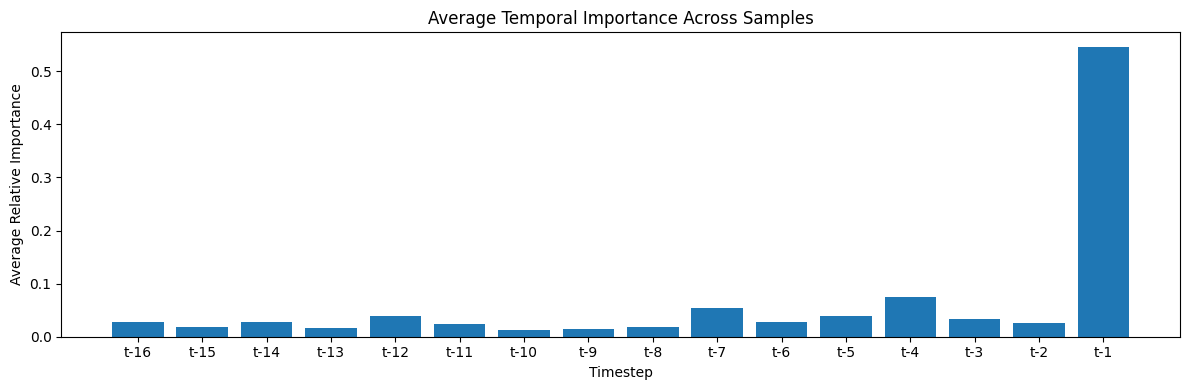


Yorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.

En önemli 10 özellik (SHAP):
            Feature  Importance
210       Close_t-1    0.038681
215       SMA_5_t-1    0.033663
212         Low_t-1    0.033066
220  Upper_Band_t-1    0.026842
213        Open_t-1    0.026549
211        High_t-1    0.023504
222  Lower_Band_t-1    0.016960
219      RSI_14_t-1    0.013423
171        Open_t-4    0.012362
173       SMA_5_t-4    0.004365


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from reformer_pytorch import Reformer
from google.colab import drive
import time
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])

drive.mount('/content/drive')

class ReformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, depth, heads, bucket_size, n_hashes, output_dim=1):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, bucket_size * 2, d_model))

        self.input_dropout = nn.Dropout(0.1)

        self.reformer = Reformer(
            dim=d_model,
            depth=depth,
            heads=heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=True
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoding
        x = self.input_dropout(x)
        x = self.reformer(x)
        x = self.layer_norm(x)
        x = x[:, -1, :]
        x = self.fc_out(x)
        return x

def prepare_features_for_interpretability(X, features):
    """
    Prepare feature names for interpretability methods with time series data

    Args:
        X: Input data with shape (samples, seq_length, features)
        features: List of feature names

    Returns:
        X_reshaped: Reshaped data with shape (samples, seq_length*features)
        feature_names: Expanded list of feature names including timesteps
    """
    seq_length = X.shape[1]
    feature_names = []

    for t in range(seq_length):
        for f in features:
            feature_names.append(f"{f}_t-{seq_length-t}")


    X_reshaped = X.reshape(X.shape[0], -1)

    return X_reshaped, feature_names

def explain_with_shap(model, X_train, X_test, features, device, num_background=20, num_samples=2):
    """
    Generate SHAP explanations for the transformer model with error handling
    """
    model.eval()


    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)


    background = X_train_reshaped[:num_background]


    def model_predict(x):
      batch_size = x.shape[0]
      x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
      x_tensor = torch.FloatTensor(x_reshaped).to(device)  # Use the GPU


      sub_batch_size = 1
      outputs = []

      for i in range(0, batch_size, sub_batch_size):
          sub_batch = x_tensor[i:i+sub_batch_size]
          with torch.no_grad():
              sub_output = model(sub_batch)
          outputs.append(sub_output.cpu().numpy())

      return np.concatenate(outputs, axis=0)


    print("Creating SHAP explainer...")

    explainer = shap.KernelExplainer(model_predict, background)


    samples_to_explain = X_test_reshaped[:num_samples]

    print(f"Calculating SHAP values for {num_samples} samples...")

    shap_values = explainer.shap_values(samples_to_explain)


    if isinstance(shap_values, list):
        shap_values_for_importance = shap_values[0] if isinstance(shap_values, list) else shap_values
    else:
        shap_values_for_importance = shap_values

    if len(shap_values_for_importance.shape) > 2:
        shap_values_for_importance = shap_values_for_importance.reshape(shap_values_for_importance.shape[0], -1)

    feature_importance = np.abs(shap_values_for_importance).mean(0)

    if len(feature_names) != len(feature_importance):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importance array length ({len(feature_importance)})")
        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_names = feature_names + [f"Unknown_{i}" for i in range(len(feature_importance) - len(feature_names))]

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    top_n = 15
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(12, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Ortalama |SHAP Değeri|')
    plt.title(f'En Önemli {top_n} Özellik (SHAP)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    feature_importance_df.to_csv(f'{result_dir}/shap_feature_importance.csv')

    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, samples_to_explain, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{result_dir}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating SHAP summary plot: {e}")

    return {
        'shap_values': shap_values,
        'feature_importance': feature_importance_df
    }

def explain_with_lime(model, X_train, X_test, features, device, num_samples=5):
    """
    Generate LIME explanations for the transformer model
    """
    model_cpu = model.to('cpu')
    model_cpu.eval()

    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)

    def predict_fn(x):
        batch_size = x.shape[0]
        x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
        x_tensor = torch.FloatTensor(x_reshaped)

        with torch.no_grad():
            output = model_cpu(x_tensor)
        return output.numpy()

    print("Creating LIME explainer...")
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_reshaped,
        feature_names=feature_names,
        discretize_continuous=True,
        mode='regression'
    )

    print(f"Generating LIME explanations for {num_samples} samples...")
    explanations = []

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    for i in range(min(num_samples, len(X_test_reshaped))):
        try:
            exp = explainer.explain_instance(
                X_test_reshaped[i],
                predict_fn,
                num_features=20
            )
            explanations.append(exp)

            plt.figure(figsize=(10, 6))
            plt.title(f'LIME Explanation for Sample {i+1}')
            exp.as_pyplot_figure()
            plt.tight_layout()

            plt.savefig(f'{result_dir}/lime_explanation_sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            print(f"Error explaining sample {i}: {e}")

    model.to(device)

    return explanations

def analyze_temporal_importance(model, X_test, features, device, num_samples=5):
    """
    Analyze how each timestep contributes to the prediction

    Args:
        model: Trained PyTorch model
        X_test: Test data
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')
        num_samples: Number of samples to analyze
    """
    model.eval()

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    all_importances = []

    for sample_idx in range(min(num_samples, len(X_test))):
        sequence = X_test[sample_idx:sample_idx+1]
        sequence_tensor = torch.FloatTensor(sequence).to(device)

        with torch.no_grad():
            original_pred = model(sequence_tensor).item()

        importances = np.zeros(sequence.shape[1])
        for t in range(sequence.shape[1]):
            masked = sequence.copy()
            masked[0, t, :] = 0
            masked_tensor = torch.FloatTensor(masked).to(device)

            with torch.no_grad():
                masked_pred = model(masked_tensor).item()

            importances[t] = abs(original_pred - masked_pred)

        importances = importances / importances.sum() if importances.sum() > 0 else importances
        all_importances.append(importances)

        plt.figure(figsize=(12, 4))
        plt.bar(range(sequence.shape[1]), importances)
        plt.xlabel('Timestep')
        plt.ylabel('Relative Importance')
        plt.title(f'Temporal Importance for Sample {sample_idx+1}')
        plt.xticks(range(sequence.shape[1]), [f't-{sequence.shape[1]-i}' for i in range(sequence.shape[1])])
        plt.tight_layout()

        plt.savefig(f'{result_dir}/temporal_importance_sample_{sample_idx+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

    avg_importance = np.mean(all_importances, axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(avg_importance)), avg_importance)
    plt.xlabel('Timestep')
    plt.ylabel('Average Relative Importance')
    plt.title('Average Temporal Importance Across Samples')
    plt.xticks(range(len(avg_importance)), [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))])
    plt.tight_layout()

    plt.savefig(f'{result_dir}/average_temporal_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame({
        'Timestep': [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))],
        'Importance': avg_importance
    }).to_csv(f'{result_dir}/temporal_importance.csv', index=False)

def run_interpretability_analysis(model, X_train, X_test, features, device):
    """
    Run comprehensive interpretability analysis on the model

    Args:
        model: Trained PyTorch model
        X_train: Training data with shape (samples, seq_length, features)
        X_test: Test data with shape (samples, seq_length, features)
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')

    Returns:
        Dictionary with results of the analysis
    """
    print("Starting model interpretability analysis...")

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    print(f"Results will be saved to: {result_dir}")

    print("\n=== SHAP Analysis ===")
    shap_results = explain_with_shap(model, X_train, X_test, features, device)

    print("\n=== LIME Analysis ===")
    lime_results = explain_with_lime(model, X_train, X_test, features, device)

    print("\n=== Temporal Importance Analysis ===")
    analyze_temporal_importance(model, X_test, features, device)

    return {
        'shap_results': shap_results,
        'lime_results': lime_results
    }

def prepare_sequences(data, bucket_size=8):
    """Sekans hazırlama fonksiyonu"""
    seq_length = bucket_size * 2
    xs = []
    ys = []

    close_index = 0

    for i in range(0, len(data) - seq_length - 1, 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length, close_index:close_index+1]
        if len(x) == seq_length:
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)

class FinancialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def interpret_existing_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    drive.mount('/content/drive')

    features = [
        'Close',
        'High',
        'Low',
        'Open',
        'Volume',
        'SMA_5',
        'SMA_10',
        'SMA_20',
        'SMA_50',
        'RSI_14',
        'Upper_Band',
        'Middle_Band',
        'Lower_Band',
        'MACD',
    ]

    bucket_size = 8
    seq_length = bucket_size * 2

    model_params = {
        'input_dim': len(features),
        'd_model': 32,
        'depth': 1,
        'heads': 2,
        'bucket_size': bucket_size,
        'n_hashes': 2,
        'output_dim': 1
    }

    try:
        dosya_yolu = '/content/drive/MyDrive/ders/SKBNK.IS.csv'
        df = pd.read_csv(dosya_yolu)

        close_scaler = MinMaxScaler()
        df['Close_scaled'] = close_scaler.fit_transform(df[['Close']])

        other_features = [f for f in features if f != 'Close']
        scaled_features = {}
        for feature in other_features:
            scaler = MinMaxScaler()
            df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])
            scaled_features[feature] = scaler

        scaled_columns = [f'{f}_scaled' for f in features]
        scaled_data = df[scaled_columns].values

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]


        X_train, y_train = prepare_sequences(train_data, bucket_size)
        X_test, y_test = prepare_sequences(test_data, bucket_size)

        print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
        print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

        model = ReformerTimeSeries(**model_params).to(device)

        model_path = '/content/drive/MyDrive/ders/model.pth'
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Model weights loaded from: {model_path}")
        else:
            model.load_state_dict(checkpoint)
            print(f"Model (direct state_dict) loaded from: {model_path}")

        model.eval()

        print("\nModel yorumlanıyor...")
        interpretability_results = run_interpretability_analysis(
            model=model,
            X_train=X_train,
            X_test=X_test,
            features=features,
            device=device
        )

        print("\nYorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.")
        print("\nEn önemli 10 özellik (SHAP):")
        print(interpretability_results['shap_results']['feature_importance'].head(10))

    except Exception as e:
        print(f"Bir hata oluştu: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    interpret_existing_model()

# **ISCTR**

Mounted at /content/drive
Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shapes - X: (2907, 16, 14), y: (2907, 1)
Test shapes - X: (714, 16, 14), y: (714, 1)
Model (direct state_dict) loaded from: /content/drive/MyDrive/ders/model.pth

Model yorumlanıyor...
Starting model interpretability analysis...
Results will be saved to: /content/drive/MyDrive/ders/model_interpretability

=== SHAP Analysis ===
Creating SHAP explainer...
Calculating SHAP values for 2 samples...


  0%|          | 0/2 [00:00<?, ?it/s]

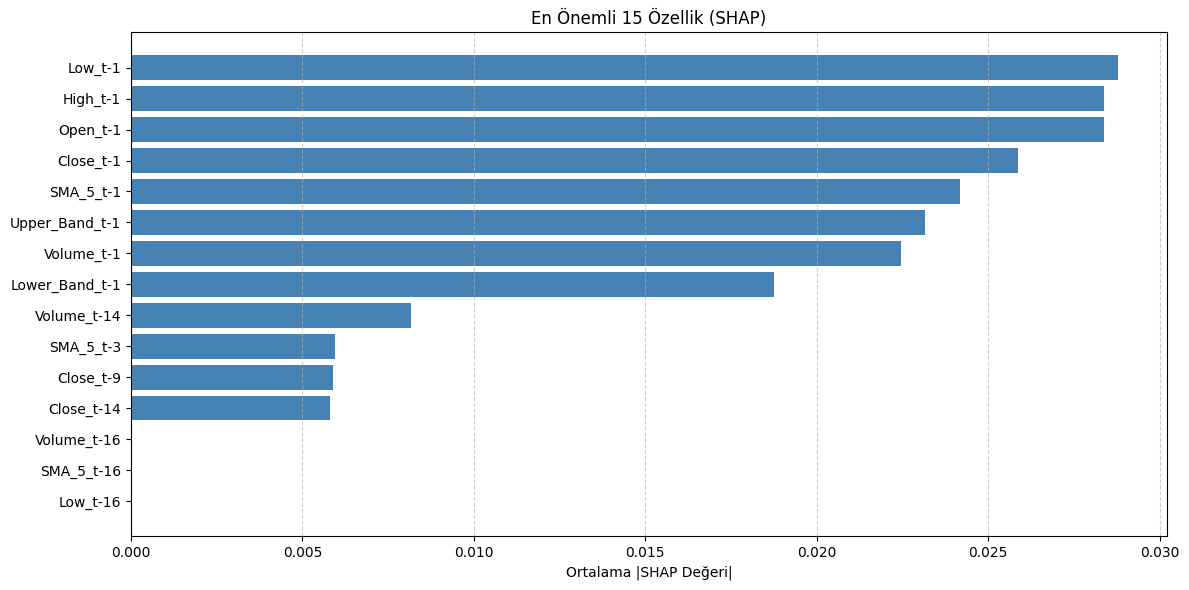


=== LIME Analysis ===
Creating LIME explainer...
Generating LIME explanations for 2 samples...

=== Temporal Importance Analysis ===


<Figure size 1200x800 with 0 Axes>

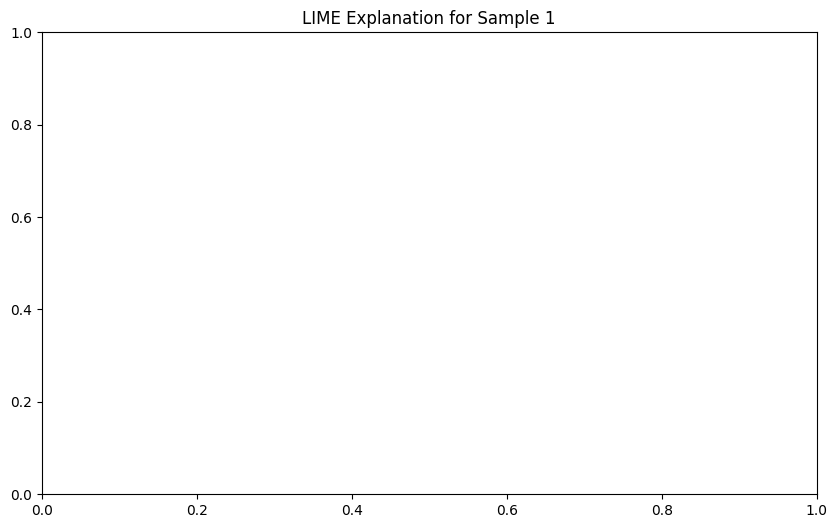

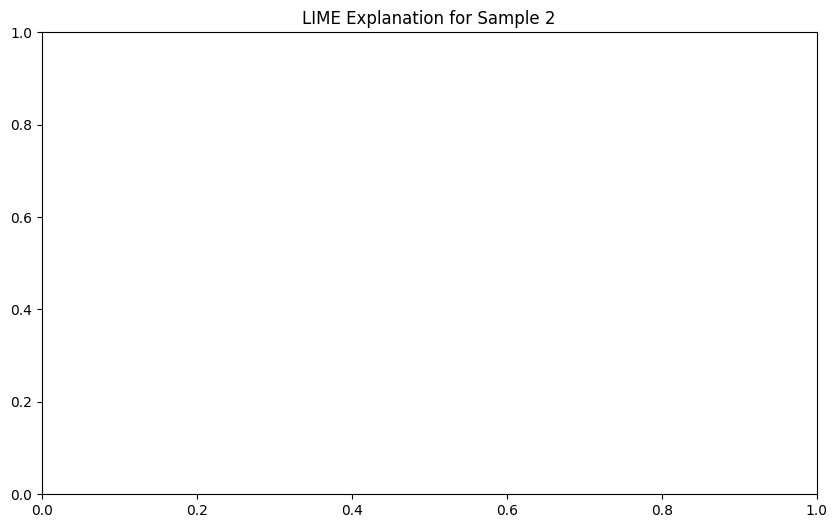

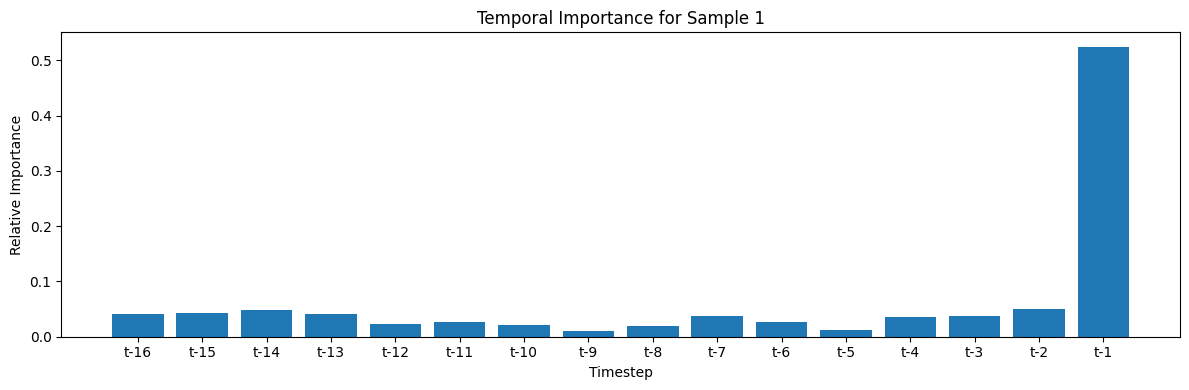

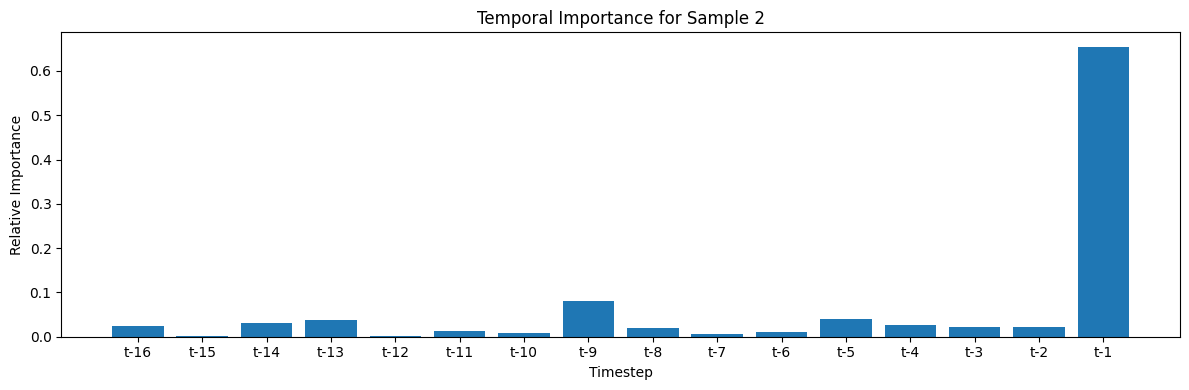

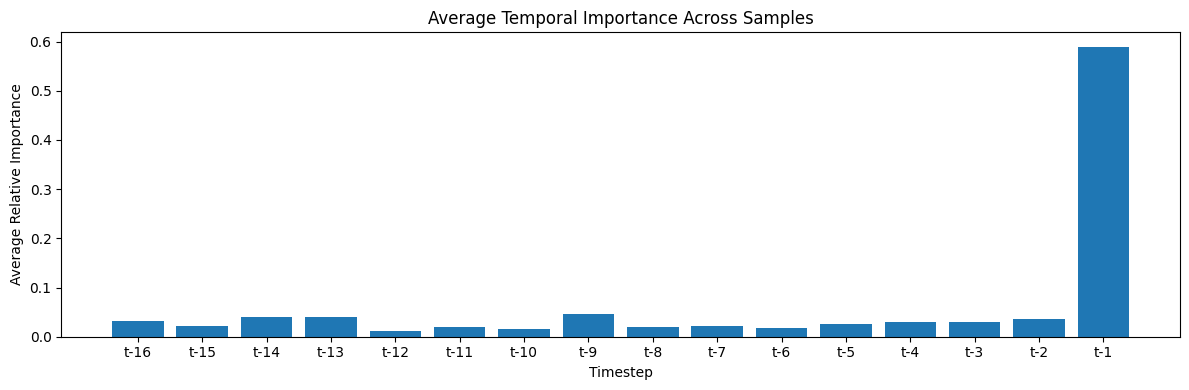


Yorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.

En önemli 10 özellik (SHAP):
            Feature  Importance
212         Low_t-1    0.028778
211        High_t-1    0.028380
213        Open_t-1    0.028376
210       Close_t-1    0.025863
215       SMA_5_t-1    0.024187
220  Upper_Band_t-1    0.023146
214      Volume_t-1    0.022446
222  Lower_Band_t-1    0.018751
32      Volume_t-14    0.008161
187       SMA_5_t-3    0.005937


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from reformer_pytorch import Reformer
from google.colab import drive
import time
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])

drive.mount('/content/drive')

class ReformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, depth, heads, bucket_size, n_hashes, output_dim=1):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, bucket_size * 2, d_model))

        self.input_dropout = nn.Dropout(0.1)

        self.reformer = Reformer(
            dim=d_model,
            depth=depth,
            heads=heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=True
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoding
        x = self.input_dropout(x)
        x = self.reformer(x)
        x = self.layer_norm(x)
        x = x[:, -1, :]
        x = self.fc_out(x)
        return x

def prepare_features_for_interpretability(X, features):
    """
    Prepare feature names for interpretability methods with time series data

    Args:
        X: Input data with shape (samples, seq_length, features)
        features: List of feature names

    Returns:
        X_reshaped: Reshaped data with shape (samples, seq_length*features)
        feature_names: Expanded list of feature names including timesteps
    """
    seq_length = X.shape[1]
    feature_names = []

    for t in range(seq_length):
        for f in features:
            feature_names.append(f"{f}_t-{seq_length-t}")


    X_reshaped = X.reshape(X.shape[0], -1)

    return X_reshaped, feature_names

def explain_with_shap(model, X_train, X_test, features, device, num_background=20, num_samples=2):
    """
    Generate SHAP explanations for the transformer model with error handling
    """
    model.eval()


    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)


    background = X_train_reshaped[:num_background]


    def model_predict(x):
      batch_size = x.shape[0]
      x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
      x_tensor = torch.FloatTensor(x_reshaped).to(device)  # Use the GPU


      sub_batch_size = 1
      outputs = []

      for i in range(0, batch_size, sub_batch_size):
          sub_batch = x_tensor[i:i+sub_batch_size]
          with torch.no_grad():
              sub_output = model(sub_batch)
          outputs.append(sub_output.cpu().numpy())

      return np.concatenate(outputs, axis=0)


    print("Creating SHAP explainer...")

    explainer = shap.KernelExplainer(model_predict, background)


    samples_to_explain = X_test_reshaped[:num_samples]

    print(f"Calculating SHAP values for {num_samples} samples...")

    shap_values = explainer.shap_values(samples_to_explain)


    if isinstance(shap_values, list):
        shap_values_for_importance = shap_values[0] if isinstance(shap_values, list) else shap_values
    else:
        shap_values_for_importance = shap_values

    if len(shap_values_for_importance.shape) > 2:
        shap_values_for_importance = shap_values_for_importance.reshape(shap_values_for_importance.shape[0], -1)

    feature_importance = np.abs(shap_values_for_importance).mean(0)

    if len(feature_names) != len(feature_importance):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importance array length ({len(feature_importance)})")
        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_names = feature_names + [f"Unknown_{i}" for i in range(len(feature_importance) - len(feature_names))]

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    top_n = 15
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(12, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Ortalama |SHAP Değeri|')
    plt.title(f'En Önemli {top_n} Özellik (SHAP)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    feature_importance_df.to_csv(f'{result_dir}/shap_feature_importance.csv')

    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, samples_to_explain, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{result_dir}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating SHAP summary plot: {e}")

    return {
        'shap_values': shap_values,
        'feature_importance': feature_importance_df
    }

def explain_with_lime(model, X_train, X_test, features, device, num_samples=2):
    """
    Generate LIME explanations for the transformer model
    """
    model_cpu = model.to('cpu')
    model_cpu.eval()

    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)

    def predict_fn(x):
        batch_size = x.shape[0]
        x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
        x_tensor = torch.FloatTensor(x_reshaped)

        with torch.no_grad():
            output = model_cpu(x_tensor)
        return output.numpy()

    print("Creating LIME explainer...")
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_reshaped,
        feature_names=feature_names,
        discretize_continuous=True,
        mode='regression'
    )

    print(f"Generating LIME explanations for {num_samples} samples...")
    explanations = []

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    for i in range(min(num_samples, len(X_test_reshaped))):
        try:
            exp = explainer.explain_instance(
                X_test_reshaped[i],
                predict_fn,
                num_features=20
            )
            explanations.append(exp)

            plt.figure(figsize=(10, 6))
            plt.title(f'LIME Explanation for Sample {i+1}')
            exp.as_pyplot_figure()
            plt.tight_layout()

            plt.savefig(f'{result_dir}/lime_explanation_sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            print(f"Error explaining sample {i}: {e}")

    model.to(device)

    return explanations

def analyze_temporal_importance(model, X_test, features, device, num_samples=2):
    """
    Analyze how each timestep contributes to the prediction

    Args:
        model: Trained PyTorch model
        X_test: Test data
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')
        num_samples: Number of samples to analyze
    """
    model.eval()

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    all_importances = []

    for sample_idx in range(min(num_samples, len(X_test))):
        sequence = X_test[sample_idx:sample_idx+1]
        sequence_tensor = torch.FloatTensor(sequence).to(device)

        with torch.no_grad():
            original_pred = model(sequence_tensor).item()

        importances = np.zeros(sequence.shape[1])
        for t in range(sequence.shape[1]):
            masked = sequence.copy()
            masked[0, t, :] = 0
            masked_tensor = torch.FloatTensor(masked).to(device)

            with torch.no_grad():
                masked_pred = model(masked_tensor).item()

            importances[t] = abs(original_pred - masked_pred)

        importances = importances / importances.sum() if importances.sum() > 0 else importances
        all_importances.append(importances)

        plt.figure(figsize=(12, 4))
        plt.bar(range(sequence.shape[1]), importances)
        plt.xlabel('Timestep')
        plt.ylabel('Relative Importance')
        plt.title(f'Temporal Importance for Sample {sample_idx+1}')
        plt.xticks(range(sequence.shape[1]), [f't-{sequence.shape[1]-i}' for i in range(sequence.shape[1])])
        plt.tight_layout()

        plt.savefig(f'{result_dir}/temporal_importance_sample_{sample_idx+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

    avg_importance = np.mean(all_importances, axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(avg_importance)), avg_importance)
    plt.xlabel('Timestep')
    plt.ylabel('Average Relative Importance')
    plt.title('Average Temporal Importance Across Samples')
    plt.xticks(range(len(avg_importance)), [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))])
    plt.tight_layout()

    plt.savefig(f'{result_dir}/average_temporal_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame({
        'Timestep': [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))],
        'Importance': avg_importance
    }).to_csv(f'{result_dir}/temporal_importance.csv', index=False)

def run_interpretability_analysis(model, X_train, X_test, features, device):
    """
    Run comprehensive interpretability analysis on the model

    Args:
        model: Trained PyTorch model
        X_train: Training data with shape (samples, seq_length, features)
        X_test: Test data with shape (samples, seq_length, features)
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')

    Returns:
        Dictionary with results of the analysis
    """
    print("Starting model interpretability analysis...")

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    print(f"Results will be saved to: {result_dir}")

    print("\n=== SHAP Analysis ===")
    shap_results = explain_with_shap(model, X_train, X_test, features, device)

    print("\n=== LIME Analysis ===")
    lime_results = explain_with_lime(model, X_train, X_test, features, device)

    print("\n=== Temporal Importance Analysis ===")
    analyze_temporal_importance(model, X_test, features, device)

    return {
        'shap_results': shap_results,
        'lime_results': lime_results
    }

def prepare_sequences(data, bucket_size=8):
    """Sekans hazırlama fonksiyonu"""
    seq_length = bucket_size * 2
    xs = []
    ys = []

    close_index = 0

    for i in range(0, len(data) - seq_length - 1, 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length, close_index:close_index+1]
        if len(x) == seq_length:
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)

class FinancialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def interpret_existing_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    drive.mount('/content/drive')

    features = [
        'Close',
        'High',
        'Low',
        'Open',
        'Volume',
        'SMA_5',
        'SMA_10',
        'SMA_20',
        'SMA_50',
        'RSI_14',
        'Upper_Band',
        'Middle_Band',
        'Lower_Band',
        'MACD',
    ]

    bucket_size = 8
    seq_length = bucket_size * 2

    model_params = {
        'input_dim': len(features),
        'd_model': 32,
        'depth': 1,
        'heads': 2,
        'bucket_size': bucket_size,
        'n_hashes': 2,
        'output_dim': 1
    }

    try:
        dosya_yolu = '/content/drive/MyDrive/ders/ISCTR.IS.csv'
        df = pd.read_csv(dosya_yolu)

        close_scaler = MinMaxScaler()
        df['Close_scaled'] = close_scaler.fit_transform(df[['Close']])

        other_features = [f for f in features if f != 'Close']
        scaled_features = {}
        for feature in other_features:
            scaler = MinMaxScaler()
            df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])
            scaled_features[feature] = scaler

        scaled_columns = [f'{f}_scaled' for f in features]
        scaled_data = df[scaled_columns].values

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]


        X_train, y_train = prepare_sequences(train_data, bucket_size)
        X_test, y_test = prepare_sequences(test_data, bucket_size)

        print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
        print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

        model = ReformerTimeSeries(**model_params).to(device)

        model_path = '/content/drive/MyDrive/ders/model.pth'
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Model weights loaded from: {model_path}")
        else:
            model.load_state_dict(checkpoint)
            print(f"Model (direct state_dict) loaded from: {model_path}")

        model.eval()

        print("\nModel yorumlanıyor...")
        interpretability_results = run_interpretability_analysis(
            model=model,
            X_train=X_train,
            X_test=X_test,
            features=features,
            device=device
        )

        print("\nYorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.")
        print("\nEn önemli 10 özellik (SHAP):")
        print(interpretability_results['shap_results']['feature_importance'].head(10))

    except Exception as e:
        print(f"Bir hata oluştu: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    interpret_existing_model()

# **AKBNK**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shapes - X: (2847, 16, 13), y: (2847, 1)
Test shapes - X: (700, 16, 13), y: (700, 1)
Model (direct state_dict) loaded from: /content/drive/MyDrive/ders/model.pth

Model yorumlanıyor...
Starting model interpretability analysis...
Results will be saved to: /content/drive/MyDrive/ders/model_interpretability

=== SHAP Analysis ===
Creating SHAP explainer...
Calculating SHAP values for 2 samples...


  0%|          | 0/2 [00:00<?, ?it/s]

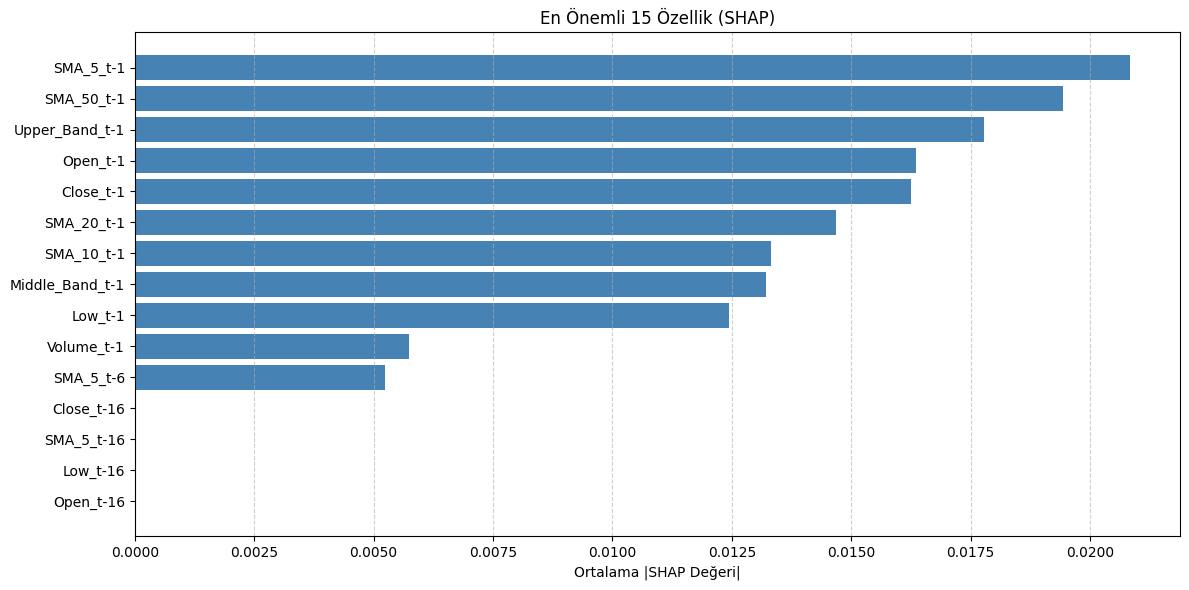


=== LIME Analysis ===
Creating LIME explainer...
Generating LIME explanations for 2 samples...

=== Temporal Importance Analysis ===


<Figure size 1200x800 with 0 Axes>

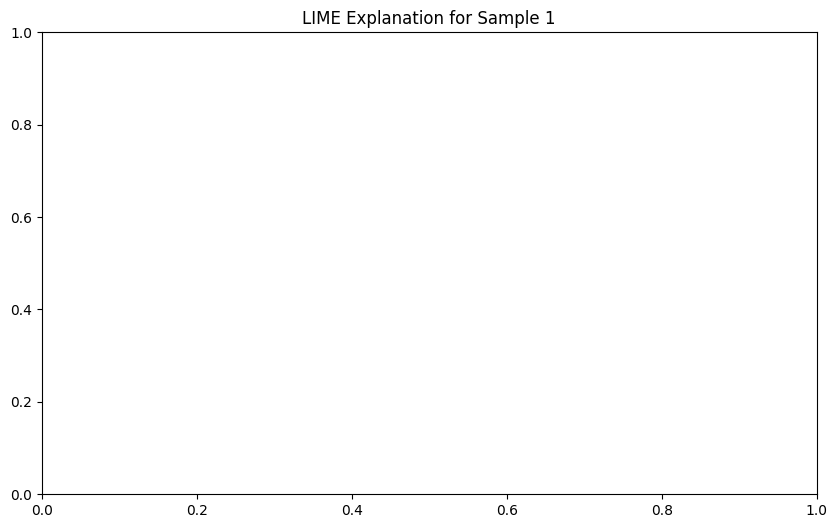

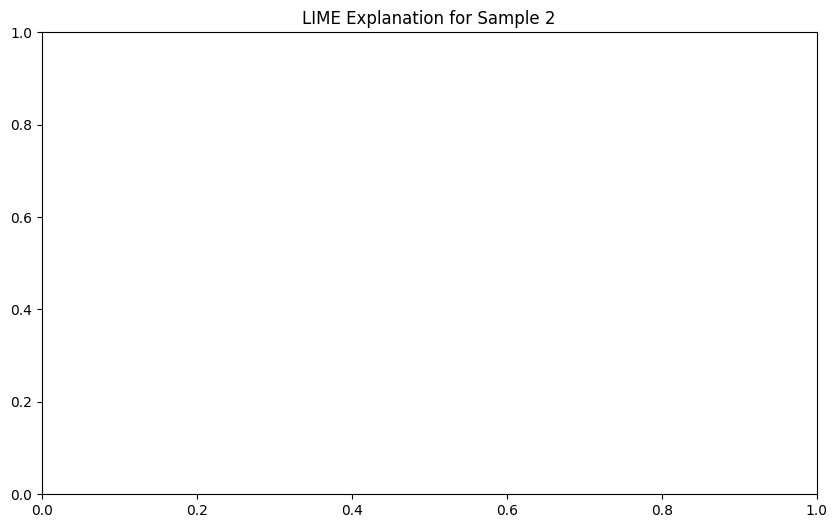

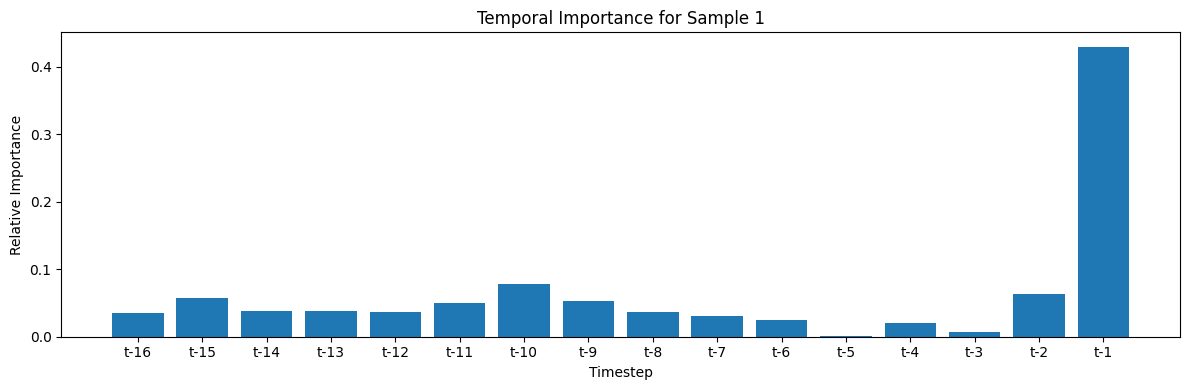

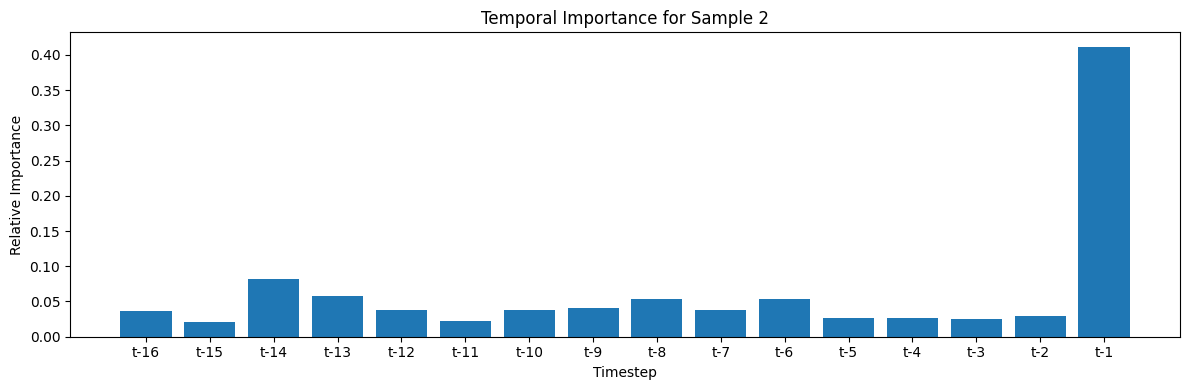

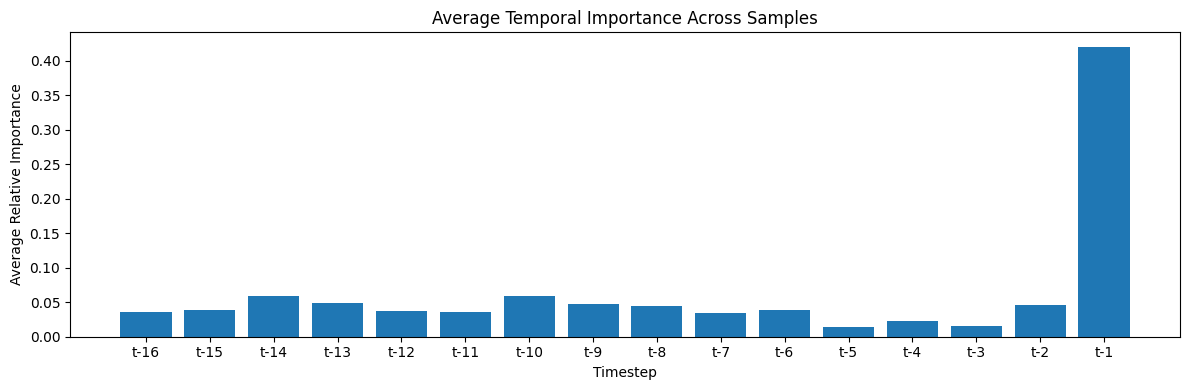


Yorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.

En önemli 10 özellik (SHAP):
             Feature  Importance
199        SMA_5_t-1    0.020844
202       SMA_50_t-1    0.019426
204   Upper_Band_t-1    0.017787
197         Open_t-1    0.016368
195        Close_t-1    0.016254
201       SMA_20_t-1    0.014687
200       SMA_10_t-1    0.013326
205  Middle_Band_t-1    0.013220
196          Low_t-1    0.012451
198       Volume_t-1    0.005733


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from reformer_pytorch import Reformer
from google.colab import drive
import time
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])

drive.mount('/content/drive')

class ReformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, depth, heads, bucket_size, n_hashes, output_dim=1):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, bucket_size * 2, d_model))

        self.input_dropout = nn.Dropout(0.1)

        self.reformer = Reformer(
            dim=d_model,
            depth=depth,
            heads=heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=True
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoding
        x = self.input_dropout(x)
        x = self.reformer(x)
        x = self.layer_norm(x)
        x = x[:, -1, :]
        x = self.fc_out(x)
        return x

def prepare_features_for_interpretability(X, features):
    """
    Prepare feature names for interpretability methods with time series data

    Args:
        X: Input data with shape (samples, seq_length, features)
        features: List of feature names

    Returns:
        X_reshaped: Reshaped data with shape (samples, seq_length*features)
        feature_names: Expanded list of feature names including timesteps
    """
    seq_length = X.shape[1]
    feature_names = []

    for t in range(seq_length):
        for f in features:
            feature_names.append(f"{f}_t-{seq_length-t}")


    X_reshaped = X.reshape(X.shape[0], -1)

    return X_reshaped, feature_names

def explain_with_shap(model, X_train, X_test, features, device, num_background=20, num_samples=2):
    """
    Generate SHAP explanations for the transformer model with error handling
    """
    model.eval()


    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)


    background = X_train_reshaped[:num_background]


    def model_predict(x):
      batch_size = x.shape[0]
      x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
      x_tensor = torch.FloatTensor(x_reshaped).to(device)  # Use the GPU


      sub_batch_size = 1
      outputs = []

      for i in range(0, batch_size, sub_batch_size):
          sub_batch = x_tensor[i:i+sub_batch_size]
          with torch.no_grad():
              sub_output = model(sub_batch)
          outputs.append(sub_output.cpu().numpy())

      return np.concatenate(outputs, axis=0)


    print("Creating SHAP explainer...")

    explainer = shap.KernelExplainer(model_predict, background)


    samples_to_explain = X_test_reshaped[:num_samples]

    print(f"Calculating SHAP values for {num_samples} samples...")

    shap_values = explainer.shap_values(samples_to_explain)


    if isinstance(shap_values, list):
        shap_values_for_importance = shap_values[0] if isinstance(shap_values, list) else shap_values
    else:
        shap_values_for_importance = shap_values

    if len(shap_values_for_importance.shape) > 2:
        shap_values_for_importance = shap_values_for_importance.reshape(shap_values_for_importance.shape[0], -1)

    feature_importance = np.abs(shap_values_for_importance).mean(0)

    if len(feature_names) != len(feature_importance):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importance array length ({len(feature_importance)})")
        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_names = feature_names + [f"Unknown_{i}" for i in range(len(feature_importance) - len(feature_names))]

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    top_n = 15
    top_features = feature_importance_df.head(top_n)
    plt.figure(figsize=(12, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
    plt.xlabel('Ortalama |SHAP Değeri|')
    plt.title(f'En Önemli {top_n} Özellik (SHAP)')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    feature_importance_df.to_csv(f'{result_dir}/shap_feature_importance.csv')

    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, samples_to_explain, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{result_dir}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating SHAP summary plot: {e}")

    return {
        'shap_values': shap_values,
        'feature_importance': feature_importance_df
    }

def explain_with_lime(model, X_train, X_test, features, device, num_samples=2):
    """
    Generate LIME explanations for the transformer model
    """
    model_cpu = model.to('cpu')
    model_cpu.eval()

    X_train_reshaped, feature_names = prepare_features_for_interpretability(X_train, features)
    X_test_reshaped, _ = prepare_features_for_interpretability(X_test, features)

    def predict_fn(x):
        batch_size = x.shape[0]
        x_reshaped = x.reshape(batch_size, X_train.shape[1], X_train.shape[2])
        x_tensor = torch.FloatTensor(x_reshaped)

        with torch.no_grad():
            output = model_cpu(x_tensor)
        return output.numpy()

    print("Creating LIME explainer...")
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_reshaped,
        feature_names=feature_names,
        discretize_continuous=True,
        mode='regression'
    )

    print(f"Generating LIME explanations for {num_samples} samples...")
    explanations = []

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    for i in range(min(num_samples, len(X_test_reshaped))):
        try:
            exp = explainer.explain_instance(
                X_test_reshaped[i],
                predict_fn,
                num_features=20
            )
            explanations.append(exp)

            plt.figure(figsize=(10, 6))
            plt.title(f'LIME Explanation for Sample {i+1}')
            exp.as_pyplot_figure()
            plt.tight_layout()

            plt.savefig(f'{result_dir}/lime_explanation_sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
        except Exception as e:
            print(f"Error explaining sample {i}: {e}")

    model.to(device)

    return explanations

def analyze_temporal_importance(model, X_test, features, device, num_samples=2):
    """
    Analyze how each timestep contributes to the prediction

    Args:
        model: Trained PyTorch model
        X_test: Test data
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')
        num_samples: Number of samples to analyze
    """
    model.eval()

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)

    all_importances = []

    for sample_idx in range(min(num_samples, len(X_test))):
        sequence = X_test[sample_idx:sample_idx+1]
        sequence_tensor = torch.FloatTensor(sequence).to(device)

        with torch.no_grad():
            original_pred = model(sequence_tensor).item()

        importances = np.zeros(sequence.shape[1])
        for t in range(sequence.shape[1]):
            masked = sequence.copy()
            masked[0, t, :] = 0
            masked_tensor = torch.FloatTensor(masked).to(device)

            with torch.no_grad():
                masked_pred = model(masked_tensor).item()

            importances[t] = abs(original_pred - masked_pred)

        importances = importances / importances.sum() if importances.sum() > 0 else importances
        all_importances.append(importances)

        plt.figure(figsize=(12, 4))
        plt.bar(range(sequence.shape[1]), importances)
        plt.xlabel('Timestep')
        plt.ylabel('Relative Importance')
        plt.title(f'Temporal Importance for Sample {sample_idx+1}')
        plt.xticks(range(sequence.shape[1]), [f't-{sequence.shape[1]-i}' for i in range(sequence.shape[1])])
        plt.tight_layout()

        plt.savefig(f'{result_dir}/temporal_importance_sample_{sample_idx+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

    avg_importance = np.mean(all_importances, axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(range(len(avg_importance)), avg_importance)
    plt.xlabel('Timestep')
    plt.ylabel('Average Relative Importance')
    plt.title('Average Temporal Importance Across Samples')
    plt.xticks(range(len(avg_importance)), [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))])
    plt.tight_layout()

    plt.savefig(f'{result_dir}/average_temporal_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame({
        'Timestep': [f't-{len(avg_importance)-i}' for i in range(len(avg_importance))],
        'Importance': avg_importance
    }).to_csv(f'{result_dir}/temporal_importance.csv', index=False)

def run_interpretability_analysis(model, X_train, X_test, features, device):
    """
    Run comprehensive interpretability analysis on the model

    Args:
        model: Trained PyTorch model
        X_train: Training data with shape (samples, seq_length, features)
        X_test: Test data with shape (samples, seq_length, features)
        features: List of feature names
        device: Device to run model on ('cpu' or 'cuda')

    Returns:
        Dictionary with results of the analysis
    """
    print("Starting model interpretability analysis...")

    result_dir = '/content/drive/MyDrive/ders/model_interpretability'
    os.makedirs(result_dir, exist_ok=True)
    print(f"Results will be saved to: {result_dir}")

    print("\n=== SHAP Analysis ===")
    shap_results = explain_with_shap(model, X_train, X_test, features, device)

    print("\n=== LIME Analysis ===")
    lime_results = explain_with_lime(model, X_train, X_test, features, device)

    print("\n=== Temporal Importance Analysis ===")
    analyze_temporal_importance(model, X_test, features, device)

    return {
        'shap_results': shap_results,
        'lime_results': lime_results
    }

def prepare_sequences(data, bucket_size=8):
    """Sekans hazırlama fonksiyonu"""
    seq_length = bucket_size * 2
    xs = []
    ys = []

    close_index = 0

    for i in range(0, len(data) - seq_length - 1, 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length, close_index:close_index+1]
        if len(x) == seq_length:
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)

class FinancialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def interpret_existing_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    drive.mount('/content/drive')

    features = [
        'Close',
        'High',
        'Low',
        'Open',
        'Volume',
        'SMA_5',
        'SMA_10',
        'SMA_20',
        'SMA_50',
        'RSI_14',
        'Upper_Band',
        'Middle_Band',
        'Lower_Band',
        'MACD',
    ]

    bucket_size = 8
    seq_length = bucket_size * 2

    model_params = {
        'input_dim': len(features),
        'd_model': 32,
        'depth': 1,
        'heads': 2,
        'bucket_size': bucket_size,
        'n_hashes': 2,
        'output_dim': 1
    }

    try:
        dosya_yolu = '/content/drive/MyDrive/ders/AKBNK.IS.csv'
        df = pd.read_csv(dosya_yolu)

        close_scaler = MinMaxScaler()
        df['Close_scaled'] = close_scaler.fit_transform(df[['Close']])

        other_features = [f for f in features if f != 'Close']
        scaled_features = {}
        for feature in other_features:
            scaler = MinMaxScaler()
            df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])
            scaled_features[feature] = scaler

        scaled_columns = [f'{f}_scaled' for f in features]
        scaled_data = df[scaled_columns].values

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]


        X_train, y_train = prepare_sequences(train_data, bucket_size)
        X_test, y_test = prepare_sequences(test_data, bucket_size)

        print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
        print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

        model = ReformerTimeSeries(**model_params).to(device)

        model_path = '/content/drive/MyDrive/ders/model.pth'
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Model weights loaded from: {model_path}")
        else:
            model.load_state_dict(checkpoint)
            print(f"Model (direct state_dict) loaded from: {model_path}")

        model.eval()

        print("\nModel yorumlanıyor...")
        interpretability_results = run_interpretability_analysis(
            model=model,
            X_train=X_train,
            X_test=X_test,
            features=features,
            device=device
        )

        print("\nYorumlama tamamlandı. Sonuçlar Drive'a kaydedildi.")
        print("\nEn önemli 10 özellik (SHAP):")
        print(interpretability_results['shap_results']['feature_importance'].head(10))

    except Exception as e:
        print(f"Bir hata oluştu: {e}")
        import traceback
        print(traceback.format_exc())

if __name__ == "__main__":
    interpret_existing_model()